<a href="https://colab.research.google.com/github/ragabhumi/Praktikum_Magnetbumi/blob/main/Pemodelan_Magnet_Bumi_RTE_RTP_FHD_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PEMODELAN DATA MAGNET BUMI - 2024**

**Pemodelan Magnet Bumi menggunakan Data Global**

oleh: Yosi Setiawan

Diklat Geofisika Potensial, 5 September 2024

Pada praktik pengolahan data magnet bumi ini, software yang digunakan adalah Fatiando a Terra (Uieda et.al., 2013) untuk analisis data magnet bumi, dan PyGMT (Uieda et.al., 2023) untuk visualisasi yang keduanya berbasis Python. Pengolahan dilakukan di Google Colab untuk memudahkan akses terhadap program dan data yang digunakan tanpa harus menginstall di komputer atau laptop masing-masing peserta.

Pada bagian ini, data yang akan digunakan adalah **data model magnet bumi EMAG2v3**.

Langkah pertama yang harus dilakukan adalah menginstal CondaColab di Google Colab di akun Google masing-masing. Tekan tombol **Run cell** di sebelah kiri setiap cell atau tekan tombol Ctrl+Enter. Tunggu hingga proses instalasi selesai. Jika muncul notifikasi **Your session crashed for an unknown reason.**, abaikan dan tutup notifikasi tersebut.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:20
🔁 Restarting kernel...


Selanjutnya, cek apakah instalasi CondaColab telah berhasil. Pastikan hasil yang muncul adalah **Everything looks OK!**.

In [ ]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


Langkah berikutnya adalah menginstal modul-modul Python yang diperlukan. Proses ini memerlukan waktu yang agak lama. Tunggulah hingga proses selesai.

In [ ]:
!mamba install verde harmonica boule pooch pygmt pandas xarray pyigrf xrft rioxarray ensaio pyproj numpy==1.26.4 cffi==1.17.0


Looking for: ['verde', 'harmonica', 'boule', 'pooch', 'pygmt', 'pandas', 'xarray', 'pyigrf', 'xrft', 'rioxarray', 'ensaio', 'pyproj', 'numpy==1.26.4', 'cffi==1.17.0']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64   3%
conda-forge/noarch    10%[+] 0.3s
conda-forge/linux-64  10%
conda-forge/noarch    25%[+] 0.4s
conda-forge/linux-64  17%
conda-forge/noarch    40%[+] 0.5s
conda-forge/linux-64  21%
conda-forge/noarch    46%[+] 0.6s
conda-forge/linux-64  23%
conda-forge/noarch    54%[+] 0.7s
conda-forge/linux-64  25%
conda-forge/noarch    60%[+] 0.8s
conda-forge/linux-64  29%
conda-forge/noarch    65%[+] 0.9s
conda-forge/linux-64  33%
conda-forge/noarch    76%[+] 1.0s
conda-forge/linux-64  38%
conda-forge/noarch    85%[+] 1.1s
conda-forge/linux-64  40%
conda-forge/noarch    94%conda-forge/noarch                                
[+] 1.2s
conda-forge/linux-64  44%[+] 1.3s
conda-forge/linux-64  52%[+] 1.4s
conda-forge/linux-64  59%[+] 1.5s


Import modul-modul Python yang akan digunakan

In [ ]:
# The standard Python science stack
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xrft
import datetime
from scipy import signal
from google.colab import files
from scipy.fftpack import fft2, ifft2, fftshift
import io

# For projections (wrapped for Proj)
import pyproj
from pyproj import Geod

# Plotting maps using GMT
import pygmt

# The Fatiando stack
import pooch
import verde as vd
import boule as bl
import harmonica as hm

Upload data magnet yang akan digunakan.

In [ ]:
path_mag = files.upload()
print(path_mag)

Saving EMAG2_V1SMTnew_clip.csv to EMAG2_V1SMTnew_clip.csv
{'EMAG2_V1SMTnew_clip.csv': b'8398,2790,99.9167,-2.98333333333333,26.7278465919094,25.2717234589745,19,116\r\n8399,2790,99.95,-2.98333333333333,24.480131854026,23.1401043872214,19,116\r\n8400,2790,99.9833,-2.98333333333333,22.1188632202794,20.8854431207524,19,116\r\n8401,2790,100.017,-2.98333333333333,19.743340693954,18.6054432705324,19,116\r\n8402,2790,100.05,-2.98333333333333,17.3993273253282,16.3491371626912,19,116\r\n8403,2790,100.083,-2.98333333333333,15.0533684379696,14.0849833378127,19,116\r\n8404,2790,100.117,-2.98333333333333,12.7968549891586,11.9052251868442,19,116\r\n8405,2790,100.15,-2.98333333333333,10.9936147346581,10.1834333726517,19,116\r\n8406,2790,100.183,-2.98333333333333,10.0560881545067,9.3252982226207,19,116\r\n8407,2790,100.217,-2.98333333333333,9.9968763829128,9.3341283844344,19,116\r\n8408,2790,100.25,-2.98333333333333,10.4960599570405,9.8920848501429,19,116\r\n8409,2790,100.283,-2.98333333333333,11.3922

Selanjutnya, data model magnet bumi dengan format csv kita parsing menggunakan modul Pandas dan diberikan nama untuk setiap kolomnya.

In [ ]:
data = pd.read_csv(io.BytesIO(path_mag['EMAG2_V1SMTnew_clip.csv']), sep=',', names=['i', 'j', 'Longitude', 'Latitude', 'Sealevel', 'UpCont', 'Code', 'Error'])
data

,i,j,Longitude,Latitude,Sealevel,UpCont,Code,Error
0,8398,2790,99.9167,-2.983333,26.727847,25.271723,19,116
1,8399,2790,99.9500,-2.983333,24.480132,23.140104,19,116
2,8400,2790,99.9833,-2.983333,22.118863,20.885443,19,116
3,8401,2790,100.0170,-2.983333,19.743341,18.605443,19,116
4,8402,2790,100.0500,-2.983333,17.399327,16.349137,19,116
...,...,...,...,...,...,...,...,...
3145,8498,2761,103.2500,-2.016667,99999.000000,-6.782114,19,116
3146,8499,2761,103.2830,-2.016667,99999.000000,-6.014426,19,116
3147,8500,2761,103.3170,-2.016667,99999.000000,-5.037395,19,116
3148,8501,2761,103.3500,-2.016667,99999.000000,-3.699612,19,116


Pada data yang kita gunakan, terdapat beberapa titik yang datanya ambigu maupun titik yang tidak ada data. Titik yang datanya ambigu diberikan kode 888 dan nilainya -888 nT, sedangkan titik yang tidak ada data diberikan kode 999 dan nilainya 99999 nT. Sehingga titik-titik tersebut harus kita hilangkan.

In [ ]:
data = data[(data['Code'] != 888) & (data['Code'] != 999)]
data

,i,j,Longitude,Latitude,Sealevel,UpCont,Code,Error
0,8398,2790,99.9167,-2.983333,26.727847,25.271723,19,116
1,8399,2790,99.9500,-2.983333,24.480132,23.140104,19,116
2,8400,2790,99.9833,-2.983333,22.118863,20.885443,19,116
3,8401,2790,100.0170,-2.983333,19.743341,18.605443,19,116
4,8402,2790,100.0500,-2.983333,17.399327,16.349137,19,116
...,...,...,...,...,...,...,...,...
3145,8498,2761,103.2500,-2.016667,99999.000000,-6.782114,19,116
3146,8499,2761,103.2830,-2.016667,99999.000000,-6.014426,19,116
3147,8500,2761,103.3170,-2.016667,99999.000000,-5.037395,19,116
3148,8501,2761,103.3500,-2.016667,99999.000000,-3.699612,19,116


Kita tampilkan titik-titik grid model magnet.

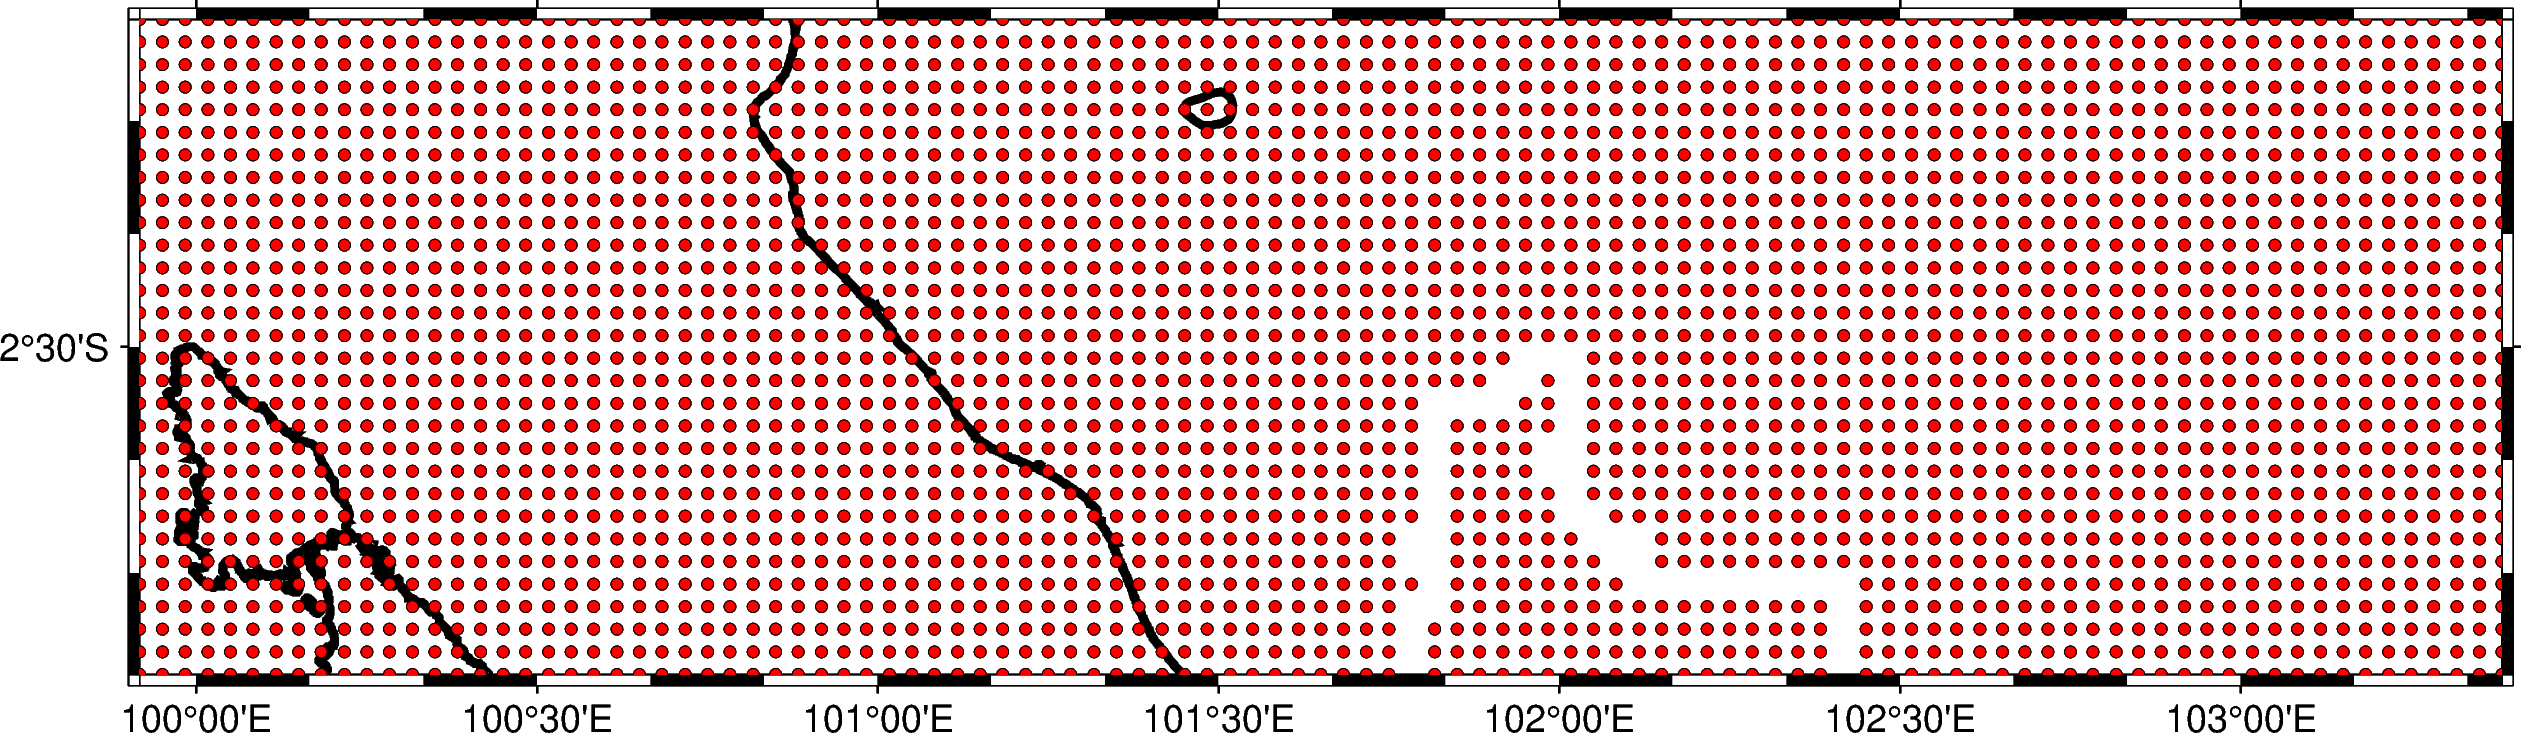

In [ ]:
# Kita atur batas koordinat sesuai dengan batasan data kita
lon_min = data['Longitude'].min()
lon_max = data['Longitude'].max()
lat_min = data['Latitude'].min()
lat_max = data['Latitude'].max()

fig = pygmt.Figure()
fig.basemap(projection='M20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.coast(resolution='f', shorelines='2p,black,solid')
fig.plot(x=data['Longitude'], y=data['Latitude'],
    style="c0.1c",
    fill="red",
    pen="faint")
fig.show()

Menampilkan peta model anomali magnet bumi dalam bentuk kontur. Pertama, kita interpolasikan dahulu data txt menjadi data grid.

In [ ]:
pre_data = pygmt.blockmean(x=data['Longitude'], y=data['Latitude'], z=data['UpCont'], region=[lon_min, lon_max, lat_min, lat_max], spacing='1m')
data_grid = pygmt.surface(pre_data, region=[lon_min, lon_max, lat_min, lat_max], spacing='1m')
data_grid

blockmean [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
blockmean (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values


<xarray.DataArray 'z' (lat: 59, lon: 209)> Size: 49kB
array([[ 25.271723 ,  24.209858 ,  23.140104 , ..., -17.409369 ,
        -16.722597 , -16.065199 ],
       [ 26.35397  ,  25.360401 ,  24.350224 , ..., -17.922922 ,
        -17.216204 , -16.534124 ],
       [ 27.43663  ,  26.521889 ,  25.582712 , ..., -18.374788 ,
        -17.649204 , -16.944592 ],
       ...,
       [ 16.918705 ,  21.007185 ,  25.168814 , ...,  -2.231187 ,
         -1.4599421,  -0.6503475],
       [ 18.168858 ,  22.270508 ,  26.423128 , ...,  -2.9360716,
         -2.1526082,  -1.3314333],
       [ 19.36204  ,  23.453352 ,  27.571407 , ...,  -3.6996121,
         -2.8980162,  -2.055729 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 472B -2.983 -2.967 -2.95 ... -2.05 -2.033 -2.017
  * lon      (lon) float64 2kB 99.92 99.93 99.95 99.97 ... 103.3 103.4 103.4
Attributes:
    Conventions:   CF-1.7
    title:         Data gridded with continuous surface splines in tension
    history:       gmt surface @GMTAPI@-S-I-D-V-T-N-000000 -G@GMTAPI@-S-O-G-G...
    description:   
    actual_range:  [nan nan]
    long_name:     z

Kita tampilkan peta konturnya menggunakan PyGMT.

<ipython-input-15-34e0b2e9293a>:6: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=data_grid, interval=20, annotation=20)


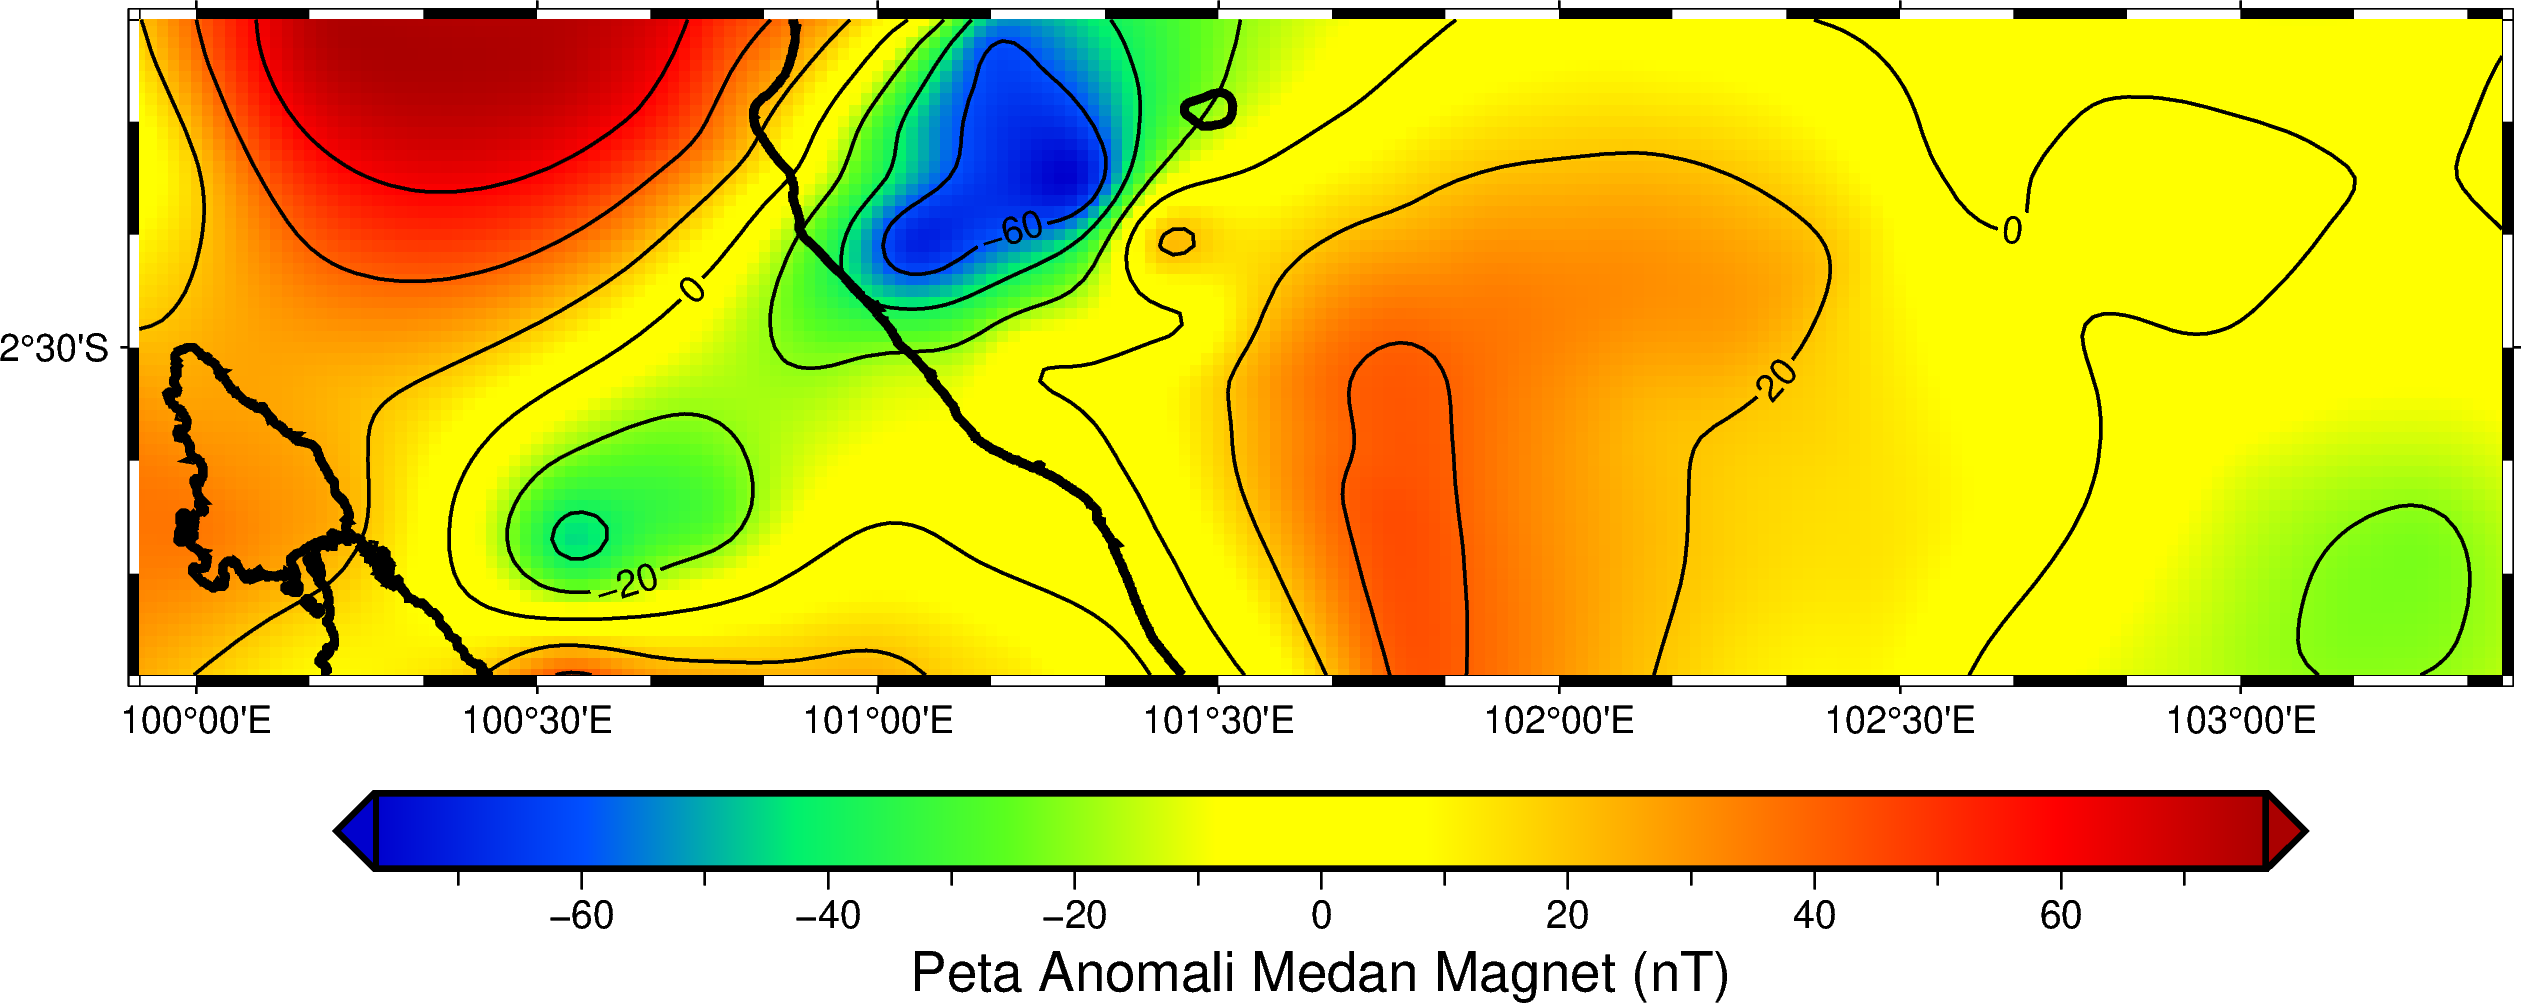

In [ ]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[data_grid.min().values, data_grid.max().values], background=True)
fig.basemap(projection='M20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=data_grid, cmap=True)
fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=data_grid, interval=20, annotation=20)

# Add colorbar
fig.colorbar(frame='af+lPeta Anomali Medan Magnet (nT)', position="JBC+h+o0/1c+e")
fig.show()

**1. Reduksi ke Ekuator**

Kita definisikan dahulu proyeksinya mengunakan pyproj.

In [ ]:
CRS = pyproj.crs.CRS(proj="merc", lat_ts=data_grid.lat.mean().values)

Selanjutnya, kita konversi data dari sistem koordinat geografis ke sistem koordinat kartesian.

In [ ]:
data_grid.rio.write_crs('+proj=lonlat', inplace=True)
utm_grid = data_grid.rio.reproject(CRS)
utm_grid = utm_grid.rename({'x':'easting', 'y':'northing'})
utm_grid

<xarray.DataArray 'z' (northing: 59, easting: 209)> Size: 49kB
array([[ 19.36204  ,  23.453352 ,  27.571407 , ...,  -3.6996121,
         -2.8980162,  -2.055729 ],
       [ 18.168858 ,  22.270508 ,  26.423128 , ...,  -2.9360716,
         -2.1526082,  -1.3314333],
       [ 16.918705 ,  21.007185 ,  25.168814 , ...,  -2.231187 ,
         -1.4599421,  -0.6503475],
       ...,
       [ 27.43663  ,  26.521889 ,  25.582712 , ..., -18.374788 ,
        -17.649204 , -16.944592 ],
       [ 26.35397  ,  25.360401 ,  24.350224 , ..., -17.922922 ,
        -17.216204 , -16.534124 ],
       [ 25.271723 ,  24.209858 ,  23.140104 , ..., -17.409369 ,
        -16.722597 , -16.065199 ]], dtype=float32)
Coordinates:
  * easting      (easting) float64 2kB 1.111e+07 1.111e+07 ... 1.15e+07 1.15e+07
  * northing     (northing) float64 472B -2.228e+05 -2.247e+05 ... -3.303e+05
    spatial_ref  int64 8B 0
Attributes:
    Conventions:   CF-1.7
    title:         Data gridded with continuous surface splines in tension
    history:       gmt surface @GMTAPI@-S-I-D-V-T-N-000000 -G@GMTAPI@-S-O-G-G...
    description:   
    actual_range:  [nan nan]
    long_name:     z
    _FillValue:    nan

Kita lakukan transformasi reduksi ke ekuator.

In [ ]:
# Mengambil data magnetik dari grid (xarray format)
magnetic_anomaly = utm_grid.values

# Parameter magnetik lokal untuk ekuator
inclination = np.radians(-30.251)  # Hampir horizontal di ekuator
declination = np.radians(0.496)  # Sesuaikan dengan lokasi

# Periksa dan ganti nilai NaN pada data asli
magnetic_anomaly = np.nan_to_num(magnetic_anomaly, nan=0.0, posinf=0.0, neginf=0.0)

# Transformasi Fourier dari data anomali magnetik
anomaly_fft = fft2(magnetic_anomaly)

# Mendapatkan dimensi grid
ny, nx = magnetic_anomaly.shape
dx = utm_grid['easting'].diff('easting').mean().values  # Resolusi grid (longitude)
dy = utm_grid['northing'].diff('northing').mean().values    # Resolusi grid (latitude)

# Membuat array frekuensi dalam arah x dan y
kx = np.fft.fftfreq(nx, dx) * 2 * np.pi
ky = np.fft.fftfreq(ny, dy) * 2 * np.pi
kx, ky = np.meshgrid(kx, ky)

# Frekuensi radial
kr = np.sqrt(kx**2 + ky**2)

# Kalkulasi filter RTE
k1 = np.cos(inclination) + 1j * np.sin(inclination) * (kx * np.cos(declination) + ky * np.sin(declination)) / (kr + np.finfo(float).eps)
rte_filter = np.abs(k1)

# Aplikasi filter RTE pada domain frekuensi
rte_anomaly_fft = anomaly_fft * rte_filter

# Transformasi balik Fourier untuk mendapatkan data RTE dalam domain spasial
rte_grid_val = np.real(ifft2(rte_anomaly_fft))

# Membuat DataArray baru dengan hasil RTE menggunakan xarray
rte_grid = xr.DataArray(rte_grid_val, dims=utm_grid.dims, coords=utm_grid.coords)

Data yang sudah ditransformasikan ke ekuator dalam sistem koordinat kartesian kita proyeksikan kembali kedalam sistem koordinat geografis.

In [ ]:
rte_grid.rio.write_crs(CRS, inplace=True)
rte_grid.rio.set_spatial_dims("easting", "northing", inplace=True)
rte_grid = rte_grid.rio.reproject('+proj=latlon')
rte_grid

<xarray.DataArray (y: 59, x: 209)> Size: 99kB
array([[ 17.89100095,  21.88376986,  25.70012612, ...,  -5.699712  ,
         -4.92968249,  -3.99458755],
       [ 16.25187882,  20.3037006 ,  24.27000535, ...,  -4.97019742,
         -4.18656337,  -3.30510299],
       [ 14.79969428,  18.80535835,  22.81259039, ...,  -4.31252526,
         -3.55464919,  -2.75379501],
       ...,
       [ 26.99087207,  26.07214428,  25.20641689, ..., -18.56113393,
        -17.91611442, -17.30526261],
       [ 25.72425106,  24.69592917,  23.80161395, ..., -18.13487296,
        -17.52700545, -17.00731458],
       [ 24.19852253,  23.17245251,  22.34372142, ..., -17.62973371,
        -17.01039647, -16.56598848]])
Coordinates:
  * x            (x) float64 2kB 99.92 99.93 99.95 99.97 ... 103.3 103.4 103.4
  * y            (y) float64 472B -2.017 -2.033 -2.05 ... -2.95 -2.967 -2.983
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  nan

Menampilkan peta anomali reduksi ke ekuator.

<ipython-input-35-2fd0f389b58d>:6: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=rte_grid, interval=20, annotation=20)


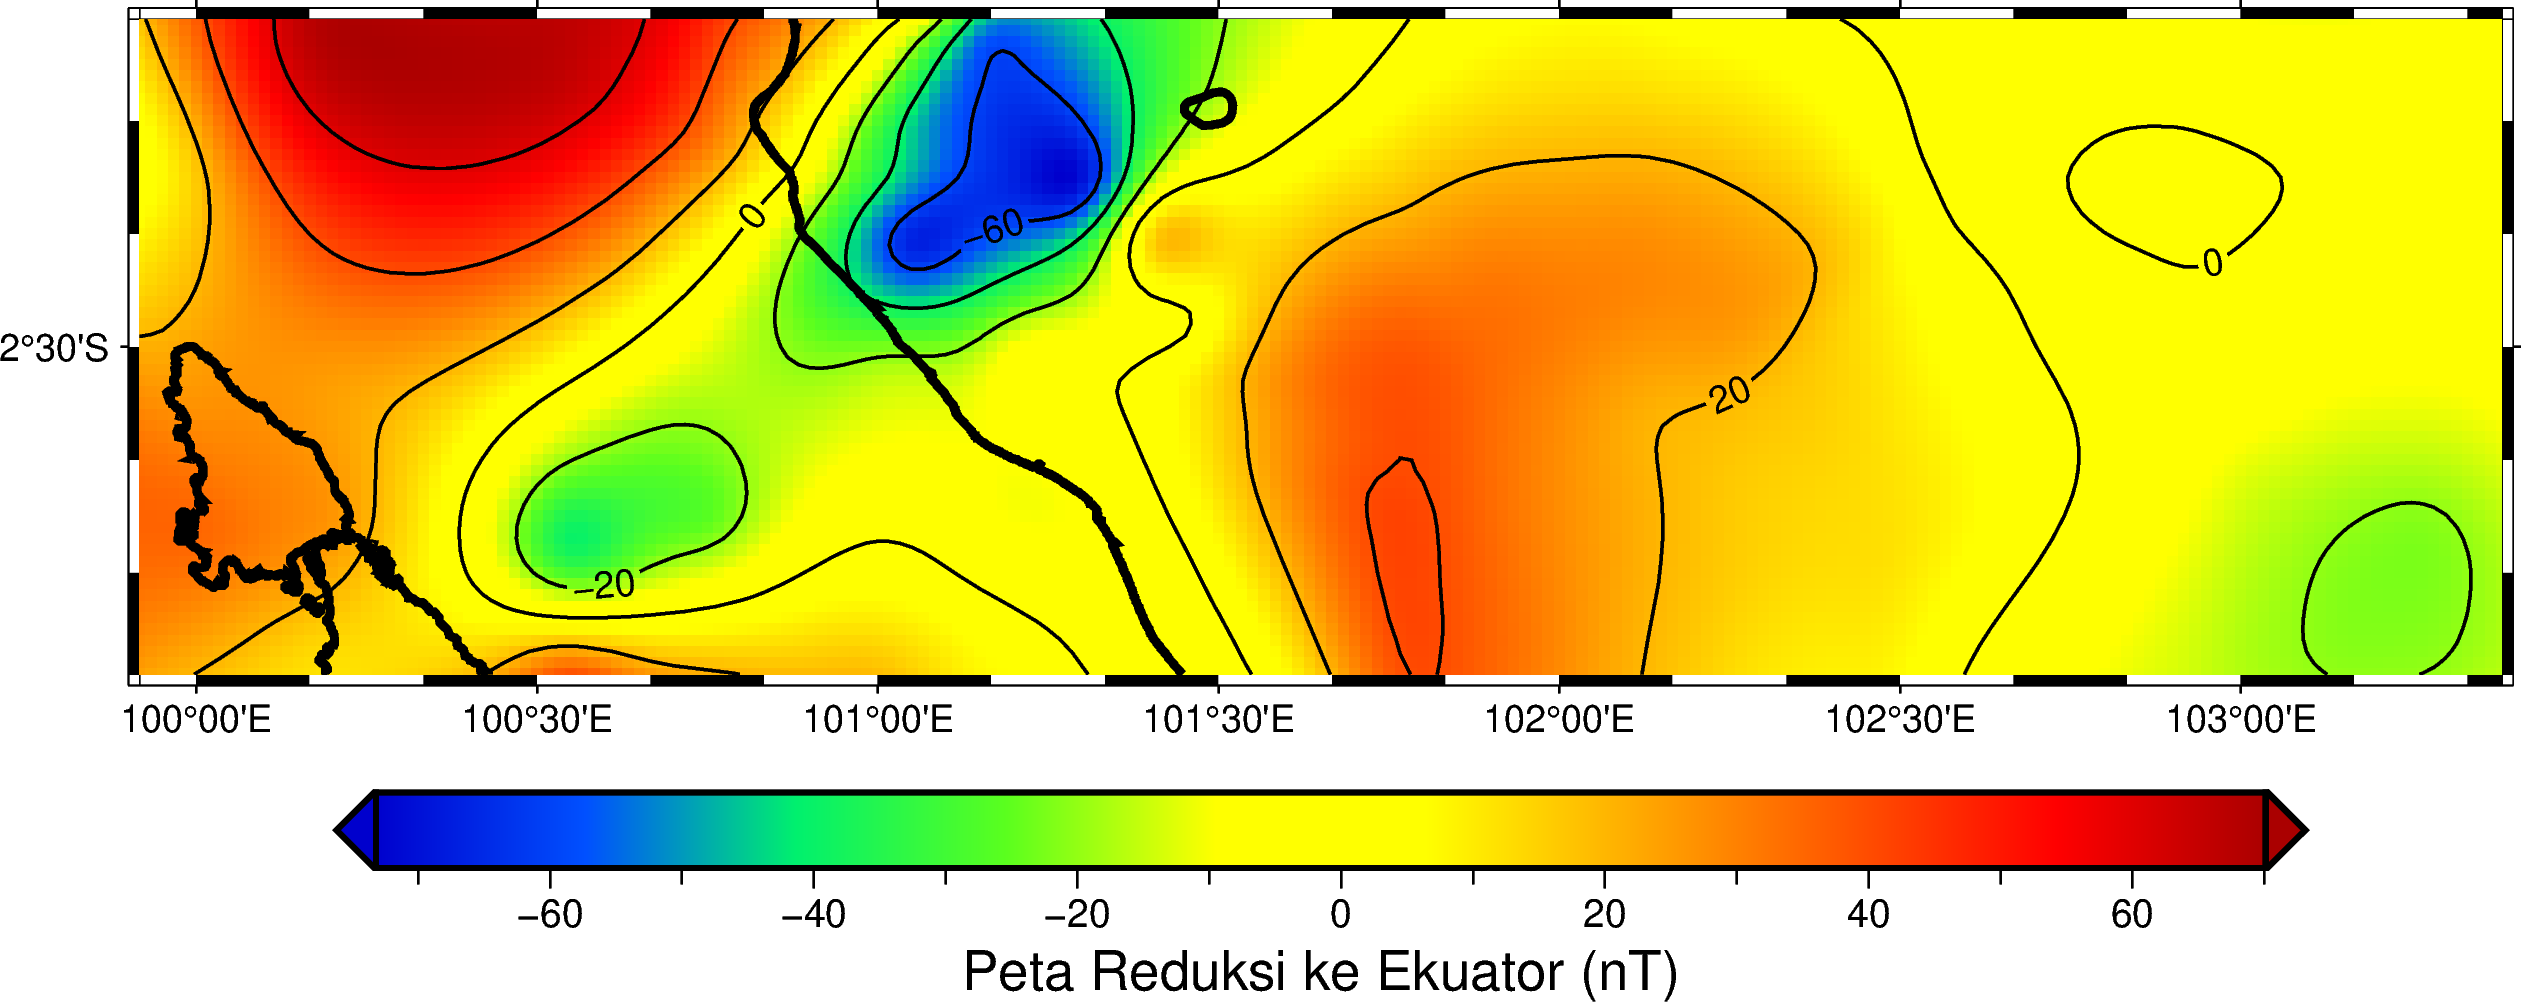

In [ ]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[rte_grid.min().values, rte_grid.max().values], background=True)
fig.basemap(projection='M20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=rte_grid, cmap=True)
fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=rte_grid, interval=20, annotation=20)

# Add colorbar
fig.colorbar(frame='af+lPeta Reduksi ke Ekuator (nT)', position="JBC+h+o0/1c+e")
fig.show()

**Download data RTE**

In [ ]:
rte_grid_df = rte_grid.to_dataframe(name='RTE')
rte_grid_df.to_csv('RTE.csv')
files.download('RTE.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Reduksi ke Kutub**


In [ ]:
# Transformasi ke kartesian
CRS = pyproj.crs.CRS(proj="merc", lat_ts=data_grid.lat.mean().values)

data_grid.rio.write_crs('+proj=lonlat', inplace=True)
utm_grid_rtp = data_grid.rio.reproject(CRS)
utm_grid_rtp = utm_grid_rtp.rename({'x':'easting', 'y':'northing'})

# Pad the grid to increase accuracy of the FFT filter
pad_width = {
    "easting": utm_grid_rtp.easting.size // 3,
    "northing": utm_grid_rtp.northing.size // 3,
}

utm_grid_rtp_pad = xrft.pad(utm_grid_rtp, pad_width)

inclination, declination = -30.92, 0.52

rtp_grid = hm.reduction_to_pole(
    utm_grid_rtp_pad, inclination=inclination, declination=declination
)

# Unpad the reduced to the pole grid
rtp_grid = xrft.unpad(rtp_grid, pad_width)

# Mengembalikan ke koordinat geografis
rtp_grid.rio.write_crs(CRS, inplace=True)
rtp_grid.rio.set_spatial_dims("easting", "northing", inplace=True)
rtp_grid = rtp_grid.rio.reproject('+proj=latlon')

/usr/local/lib/python3.11/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<ipython-input-65-903cc06c2c47>:6: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=rtp_grid, interval=20, annotation=20)


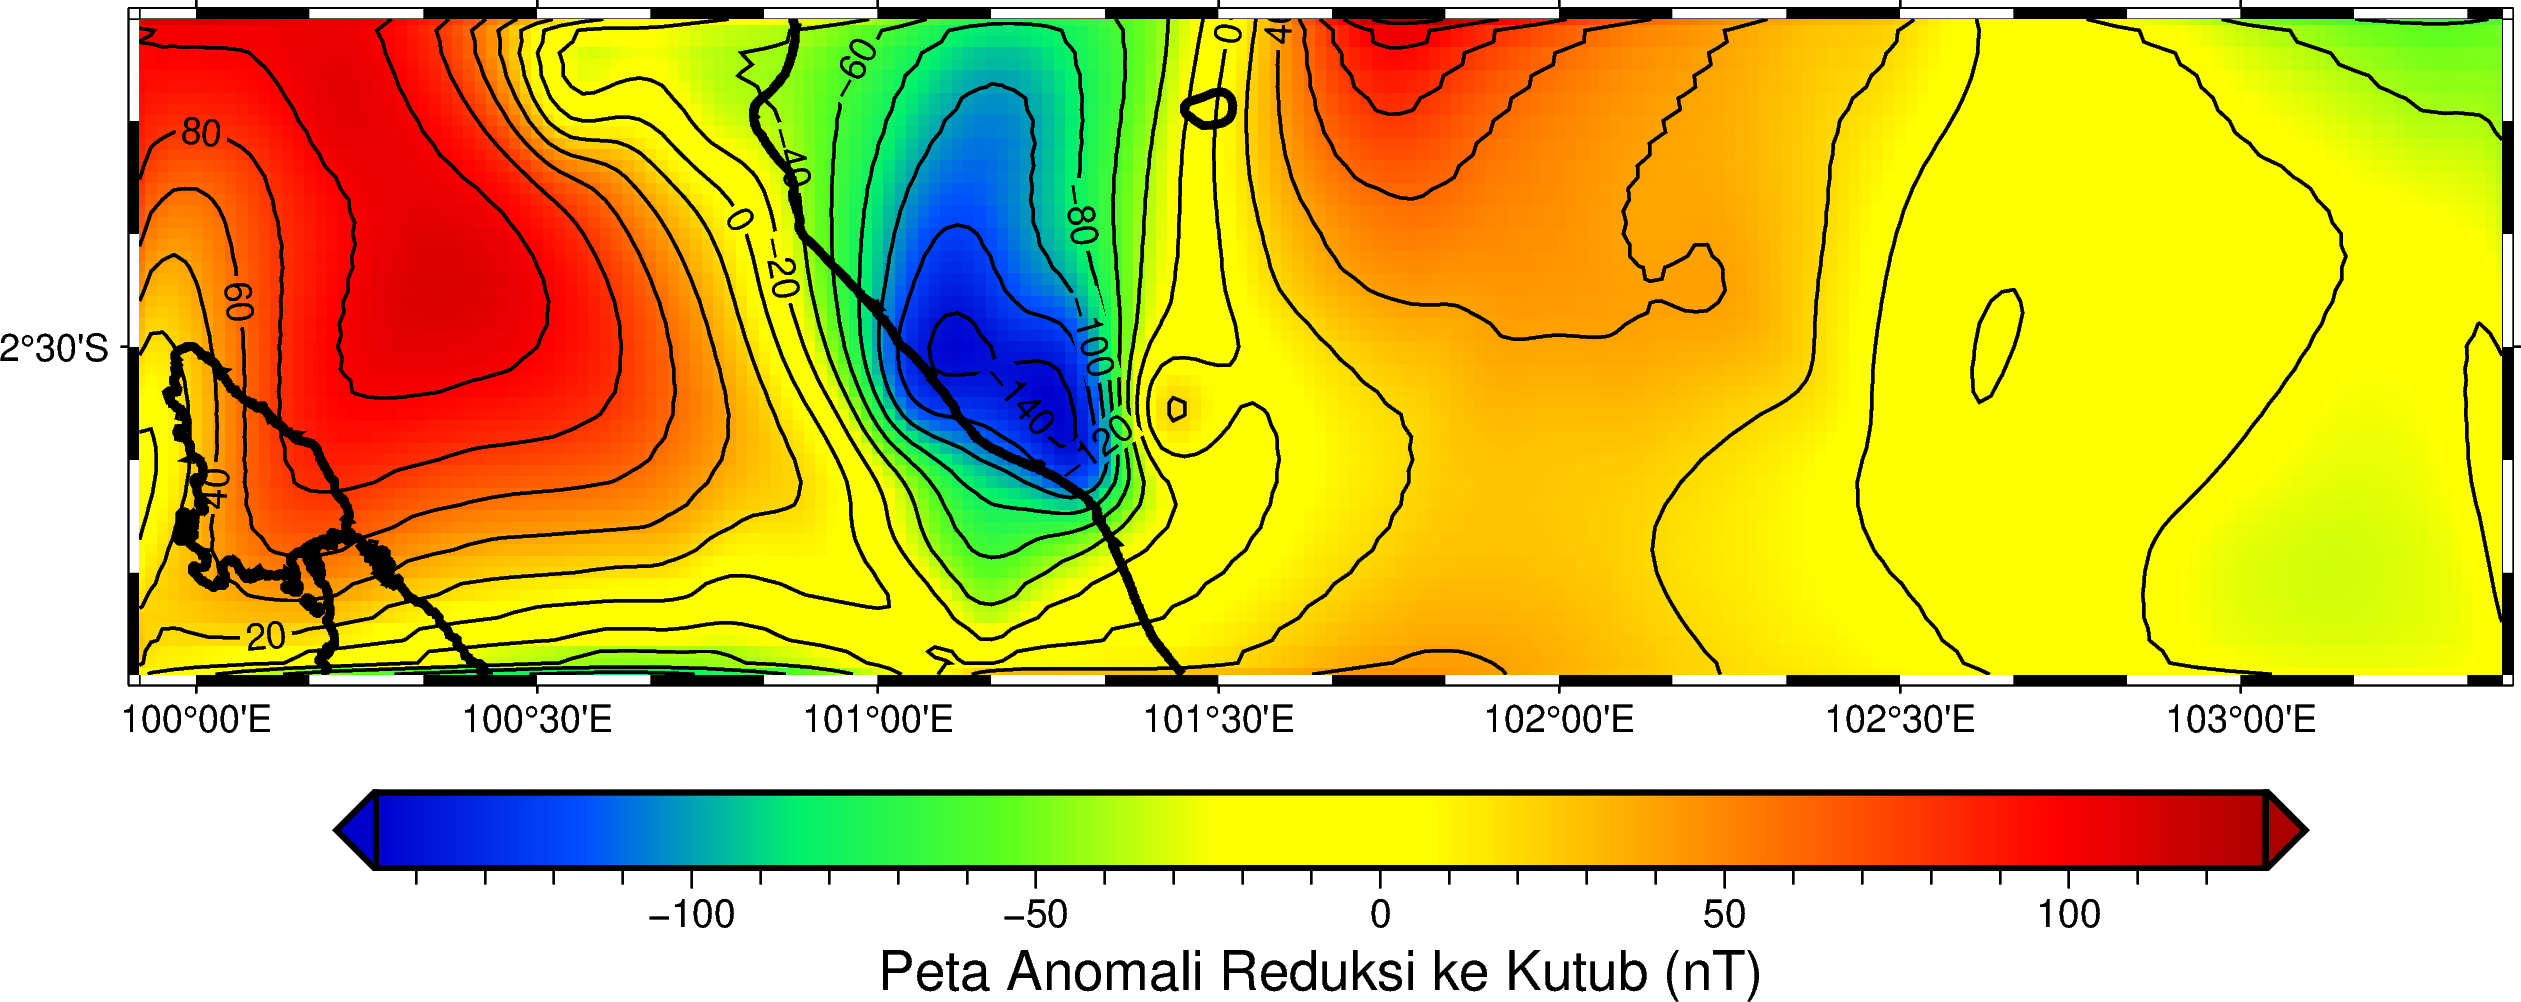

In [ ]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[rtp_grid.min().values, rtp_grid.max().values], background=True)
fig.basemap(projection='M20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=rtp_grid, cmap=True)
fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=rtp_grid, interval=20, annotation=20)

# Add colorbar
fig.colorbar(frame='af+lPeta Anomali Reduksi ke Kutub (nT)', position="JBC+h+o0/1c+e")
fig.show()

**Download data RTP**

In [ ]:
rtp_grid_df = rtp_grid.to_dataframe(name='RTP')
rtp_grid_df.to_csv('RTP.csv')
files.download('RTP.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**2. Penentuan Anomali Regional**

Untuk mendapatkan anomali residual, kita buat dahulu model anomali regionalnya. Disini kita akan menggunakan polinomial orde 2.

In [ ]:
yv, xv = np.meshgrid(rte_grid.y, rte_grid.x, indexing='ij')
coordinates = (xv, yv)
trend = vd.Trend(degree=2).fit(coordinates, rte_grid.values)

regional = rte_grid.copy()
regional = regional.rename('regional')
regional.values = trend.predict(coordinates)
regional

<xarray.DataArray 'regional' (y: 59, x: 209)> Size: 99kB
array([[34.73604349, 34.41867899, 34.10243008, ..., -7.08537471,
        -7.17292781, -7.25936531],
       [34.27811885, 33.96367954, 33.65035582, ..., -6.94071068,
        -7.02533859, -7.10885091],
       [33.82380431, 33.51229019, 33.20189165, ..., -6.79243656,
        -6.87413928, -6.95472641],
       ...,
       [14.65181433, 14.49826034, 14.34582194, ...,  6.57536136,
         6.65161877,  6.72899177],
       [14.39605517, 14.24542637, 14.09591315, ...,  6.92219086,
         7.00137346,  7.08167165],
       [14.14390611, 13.99620249, 13.84961447, ...,  7.27263046,
         7.35473825,  7.43796163]])
Coordinates:
  * x            (x) float64 2kB 99.92 99.93 99.95 99.97 ... 103.3 103.4 103.4
  * y            (y) float64 472B -2.017 -2.033 -2.05 ... -2.95 -2.967 -2.983
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  nan

Menampilkan peta anomali regional.

<ipython-input-45-3e800f4e584c>:6: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=regional, interval=20, annotation=20)


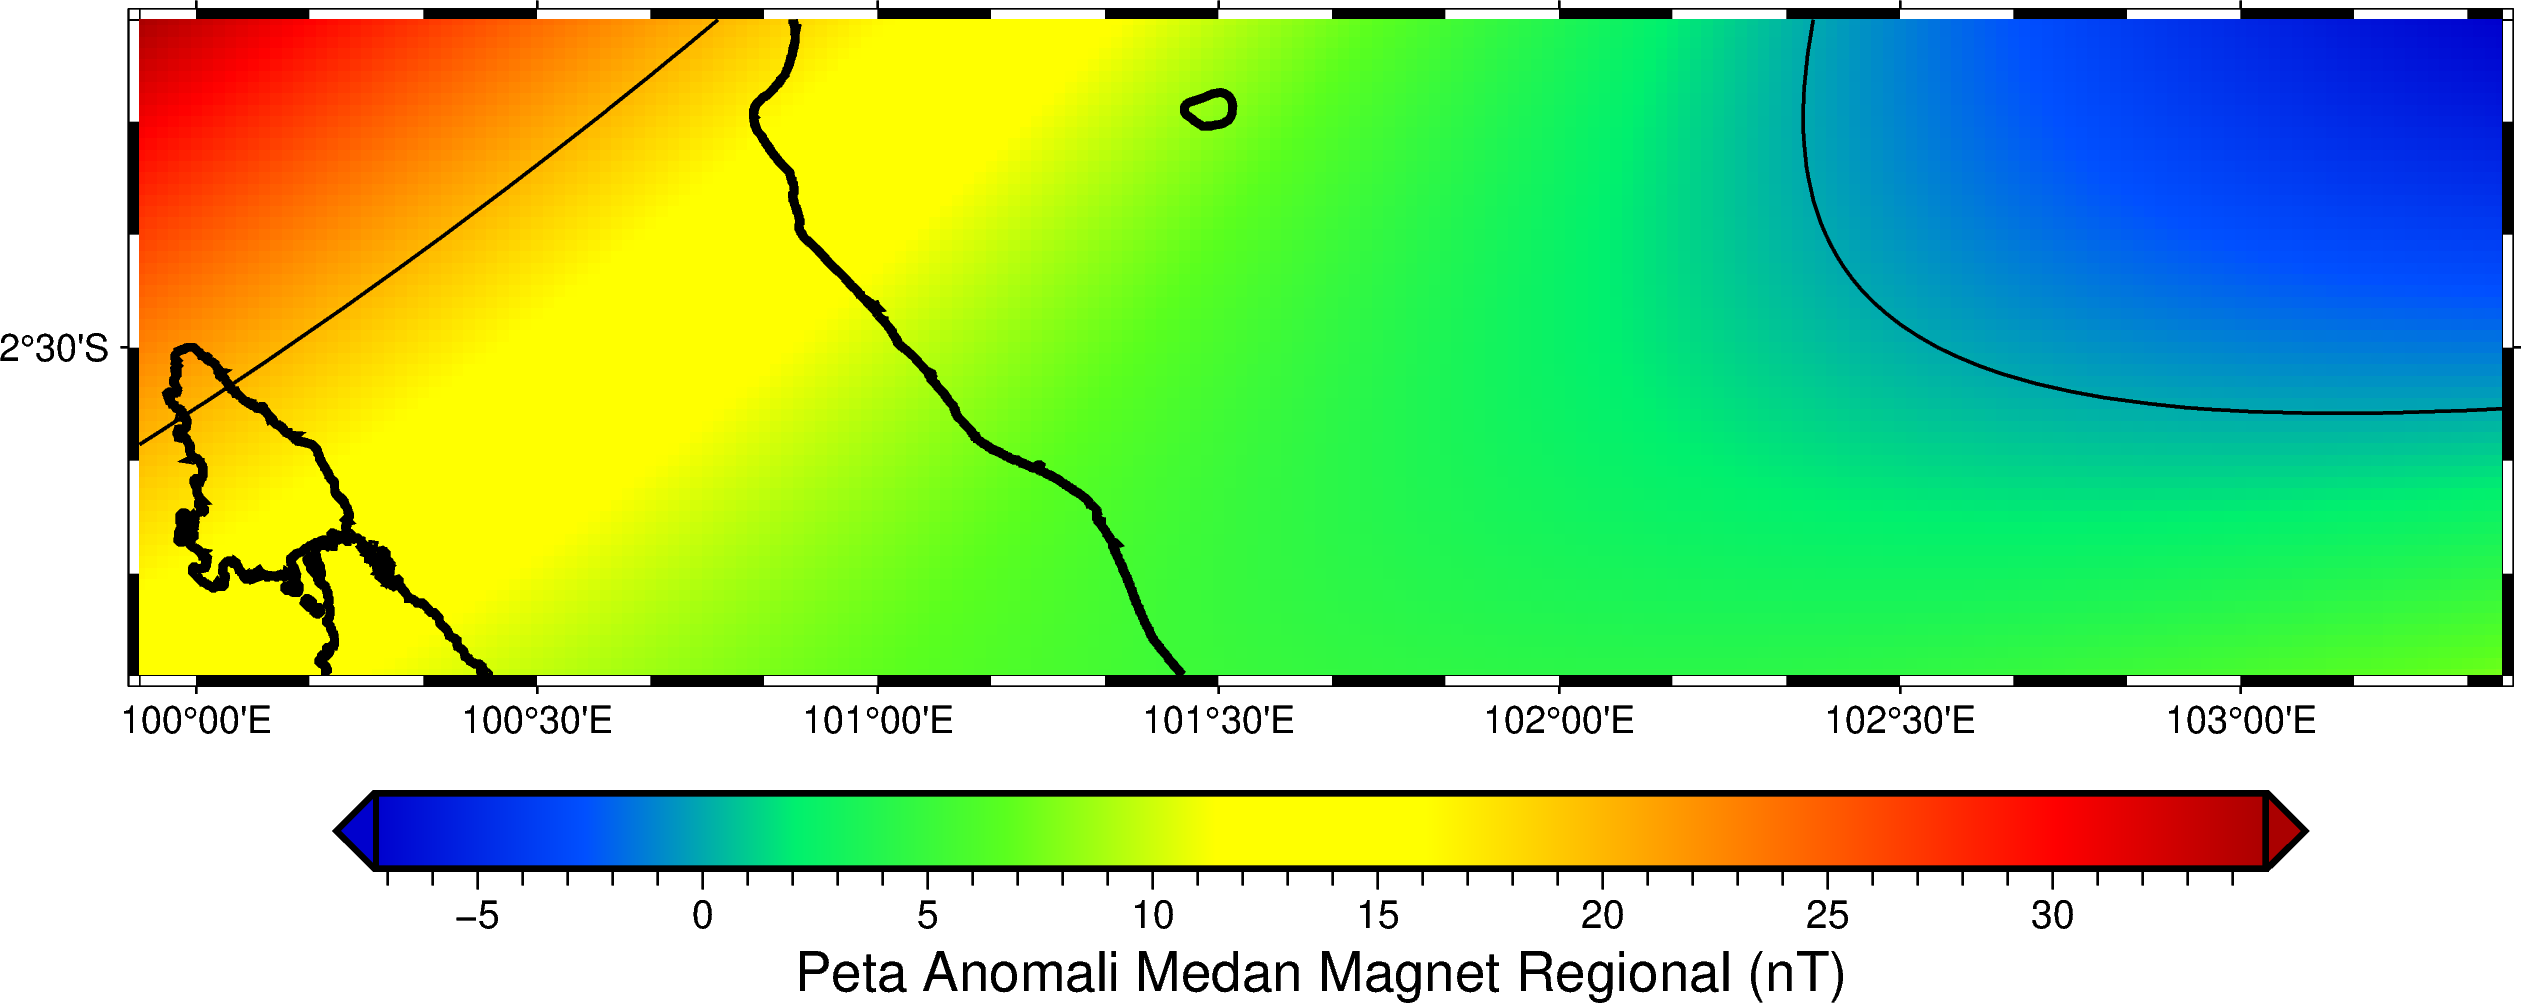

In [ ]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[regional.min().values, regional.max().values], background=True)
fig.basemap(projection='M20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=regional, cmap=True)
fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=regional, interval=20, annotation=20)

# Add colorbar
fig.colorbar(frame='af+lPeta Anomali Medan Magnet Regional (nT)', position="JBC+h+o0/1c+e")
fig.show()

**Download data Anomali Regional**

In [ ]:
regional_df = regional.to_dataframe(name='Regional')
regional_df.to_csv('Regional.csv')
files.download('Regional.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**3. Pemisahan anomali regional - residual**

In [ ]:
residual = rte_grid - regional
residual

<xarray.DataArray (y: 59, x: 209)> Size: 99kB
array([[-16.84504255, -12.53490913,  -8.40230396, ...,   1.38566271,
          2.24324531,   3.26477776],
       [-18.02624003, -13.65997894,  -9.38035046, ...,   1.97051326,
          2.83877522,   3.80374792],
       [-19.02411003, -14.70693183, -10.38930126, ...,   2.4799113 ,
          3.31949009,   4.2009314 ],
       ...,
       [ 12.33905774,  11.57388394,  10.86059495, ..., -25.13649528,
        -24.56773319, -24.03425439],
       [ 11.32819589,  10.4505028 ,   9.70570079, ..., -25.05706382,
        -24.52837891, -24.08898623],
       [ 10.05461643,   9.17625002,   8.49410695, ..., -24.90236417,
        -24.36513472, -24.00395011]])
Coordinates:
  * x            (x) float64 2kB 99.92 99.93 99.95 99.97 ... 103.3 103.4 103.4
  * y            (y) float64 472B -2.017 -2.033 -2.05 ... -2.95 -2.967 -2.983
    spatial_ref  int64 8B 0

Menampilkan peta anomali residual.

<ipython-input-48-48d4033a5c51>:6: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=residual, interval=20, annotation=20)


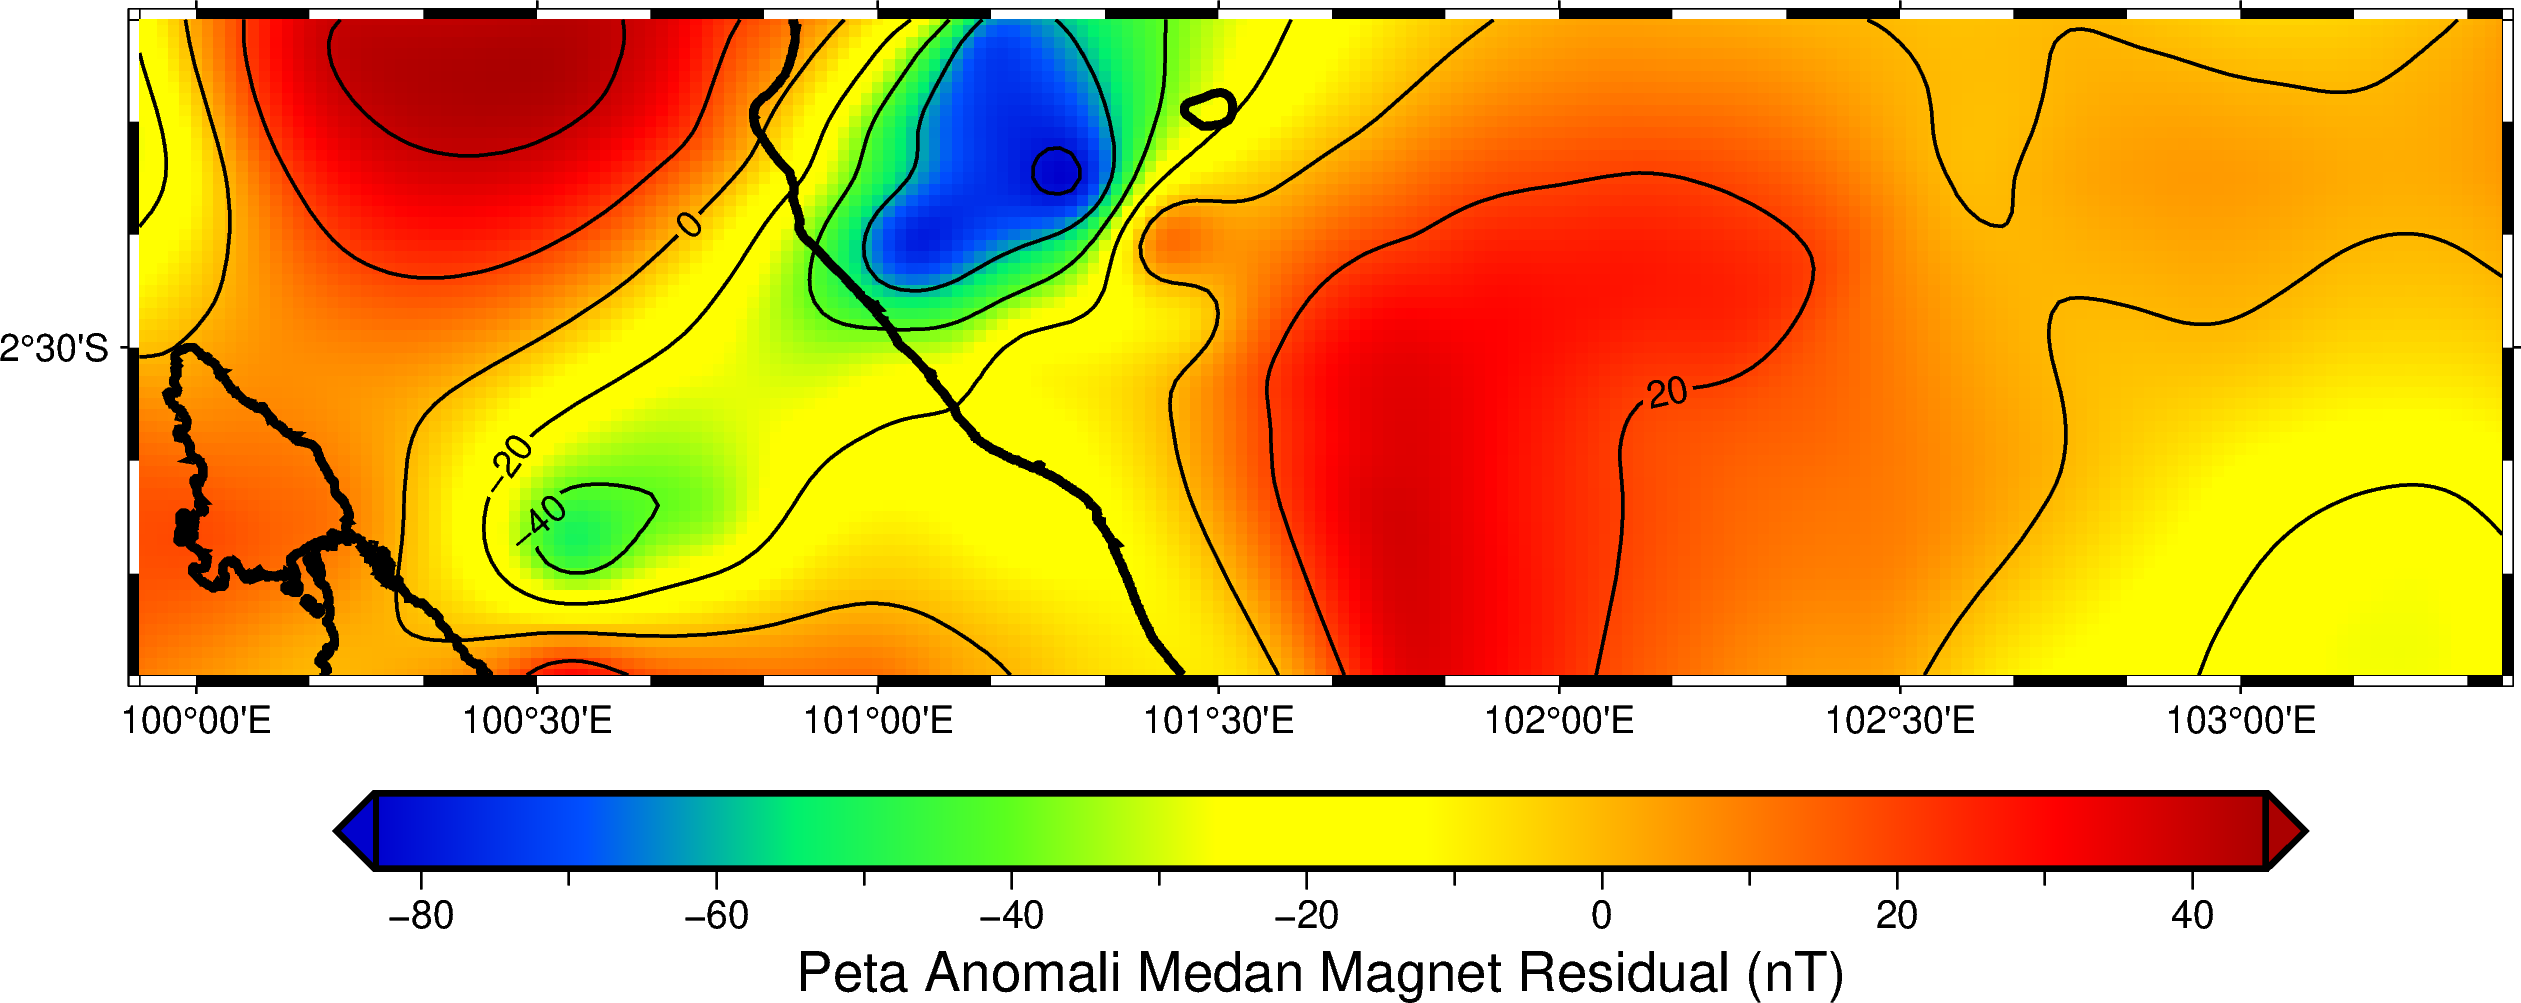

In [ ]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[residual.min().values, residual.max().values], background=True)
fig.basemap(projection='M20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=residual, cmap=True)
fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=residual, interval=20, annotation=20)

# Add colorbar
fig.colorbar(frame='af+lPeta Anomali Medan Magnet Residual (nT)', position="JBC+h+o0/1c+e")
fig.show()

**Download data Anomali Residual**

In [ ]:
residual_df = residual.to_dataframe(name='Residual')
residual_df.to_csv('Residual.csv')
files.download('Residual.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**4. First Horizontal Derivative**

Untuk mempertajam pola anomali magnetik dari peta anomali residual, diperlukan transformasi atau pengolahan data lanjutan. Proses penajaman anomali bertujuan untuk mendelineasi posisi anomali secara tepat dan juga untuk pemisahan anomali yang saling berdekatan. Salah satu metode transformasi yang dapat digunakan adalah FHD atau First Horizontal Derivative. Filter FHD dapat digunakan untuk menentukan lokasi batas kontak kontras suseptibilitas horizontal dari data magnetik.

First Horizontal Derivative (FHD) atau Turunan Mendatar Pertama mempunyai
nama lain yaitu Horizontal Gradient. FHD dari anomali magnetik yang disebabkan oleh suatu body cenderung untuk menunjukkan tepian dari body-nya tersebut. Jadi metode FHD dapat digunakan untuk menentukan lokasi
batas kontak kontras suseptibilitas horizontal magnetik.

Turunan horizontal data medan potensial dapat langsung dihitung karena
umumnya data diukur pada titik yang tersebar secara spasial (x, y). Turunan horizontal orde satu arah x dan arah ydapat dihitung melalui pendekatan berikut:

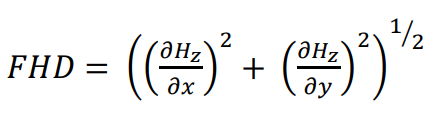

Sebelum melakukan transformasi FHD, data residual kita transformasikan dahulu ke sistem koordinat kartesian karena nilai FHD nantinya satuannya adalah nT/km.

In [ ]:
residual.rio.write_crs('+proj=lonlat', inplace=True)
utm_res = residual.rio.reproject(CRS)
utm_res = utm_res.rename({'x':'easting', 'y':'northing'})
utm_res

<xarray.DataArray (northing: 59, easting: 209)> Size: 99kB
array([[-16.84504255, -12.53490913,  -8.40230396, ...,   1.38566271,
          2.24324531,   3.26477776],
       [-18.02624003, -13.65997894,  -9.38035046, ...,   1.97051326,
          2.83877522,   3.80374792],
       [-19.02411003, -14.70693183, -10.38930126, ...,   2.4799113 ,
          3.31949009,   4.2009314 ],
       ...,
       [ 12.33905774,  11.57388394,  10.86059495, ..., -25.13649528,
        -24.56773319, -24.03425439],
       [ 11.32819589,  10.4505028 ,   9.70570079, ..., -25.05706382,
        -24.52837891, -24.08898623],
       [ 10.05461643,   9.17625002,   8.49410695, ..., -24.90236417,
        -24.36513472, -24.00395011]])
Coordinates:
  * easting      (easting) float64 2kB 1.111e+07 1.111e+07 ... 1.15e+07 1.15e+07
  * northing     (northing) float64 472B -2.228e+05 -2.247e+05 ... -3.303e+05
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  nan

Setelah data ditransformasikan ke sistem koordinat kartesian, kita bisa menghitung nilai turunan orde pertama secara horizontal ke arah sumbu X dan sumbu Y.

In [ ]:
dx = hm.derivative_easting(utm_res, order=1)
dy = hm.derivative_northing(utm_res, order=1)

FHD = np.sqrt(dx**2 + dy**2)

Setelah didapatkan nilai FHD, data kita transformasikan kembali ke sistem koordinat geografis untuk dipetakan.

In [ ]:
FHD.rio.write_crs(CRS, inplace=True)
FHD.rio.set_spatial_dims("easting", "northing", inplace=True)
FHD = FHD.rio.reproject('+proj=latlon')
FHD

<xarray.DataArray (y: 59, x: 209)> Size: 99kB
array([[0.0024123 , 0.00235814, 0.00229857, ..., 0.00053947, 0.00060045,
        0.00062344],
       [0.00242908, 0.00240593, 0.00237142, ..., 0.00053035, 0.00057373,
        0.00057891],
       [0.00239422, 0.00240067, 0.00241087, ..., 0.000494  , 0.00051711,
        0.00051173],
       ...,
       [0.00066889, 0.00070597, 0.00071902, ..., 0.00030298, 0.0002978 ,
        0.00029373],
       [0.00077754, 0.00078133, 0.00075031, ..., 0.00029646, 0.00026693,
        0.00023732],
       [0.00083509, 0.00080651, 0.00075175, ..., 0.00030384, 0.00025799,
        0.00020029]])
Coordinates:
  * x            (x) float64 2kB 99.92 99.93 99.95 99.97 ... 103.3 103.4 103.4
  * y            (y) float64 472B -2.017 -2.033 -2.05 ... -2.95 -2.967 -2.983
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  nan

Kita petakan nilai FHD.

<ipython-input-57-91f802ff4cd1>:6: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=FHD, interval=0.001, annotation=0.001)


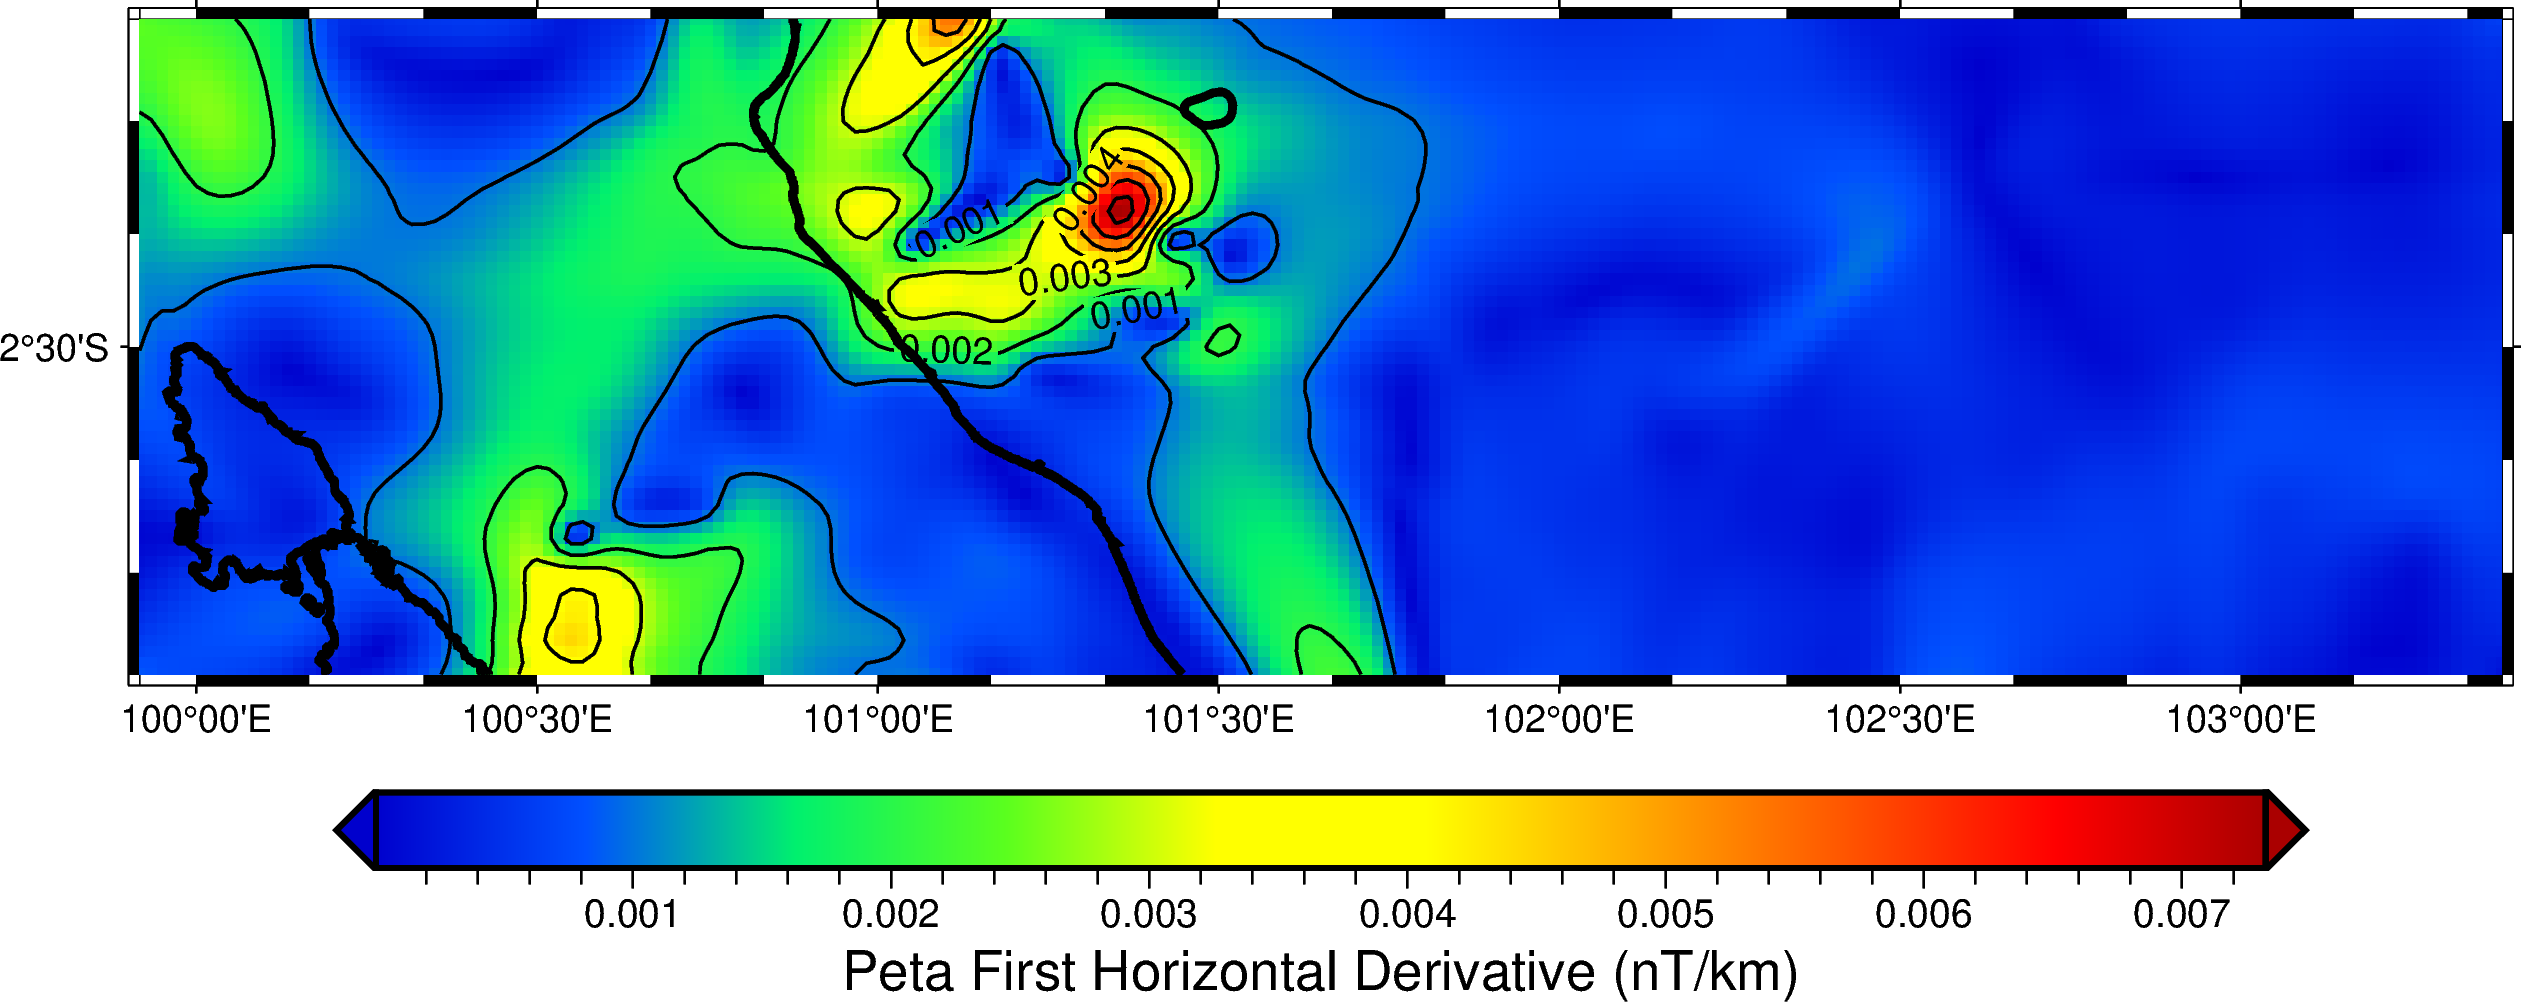

In [ ]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[FHD.min().values, FHD.max().values], background=True)
fig.basemap(projection='M20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=FHD, cmap=True)
fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=FHD, interval=0.001, annotation=0.001)

# Add colorbar
fig.colorbar(frame='af+lPeta First Horizontal Derivative (nT/km)', position="JBC+h+o0/1c+e")
fig.show()

**Download Data FHD**

In [ ]:
FHD_df = FHD.to_dataframe(name='FHD')
FHD_df.to_csv('FHD.csv')
files.download('FHD.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**5. Second Vertical Derivative**

Selain FHD, metode SVD atau Second Vertical Derivative juga dapat digunakan untuk mendelineasi sumber anomali dan dapat memperjelas pola anomali dari data medan potensial. Second Vertical Derivative (SVD)
dilakukan untuk memunculkan efek dangkal dari pengaruh regionalnya dan
untuk menentukan batas-batas struktur yang ada di daerah penelitian, sehingga filter ini dapat menyelesaikan anomali residual yang tidak mampu dipisahkan dengan metode pemisahan regional-residual yang ada. Secara teoritis, metode ini diturunkan dari persamaan Laplace’s:

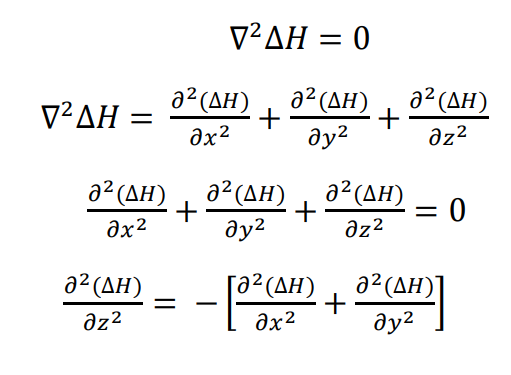

Berdasarkan persamaan diatas, dapat diketahui bahwa nilai SVD dari suatu anomali magnetik permukaan adalah sama dengan negatif dari derivative orde dua horizontalnya. SVD bersifat sebagai highpass filter, sehingga dapat menggambarkan anomali residual yang berasosiasi dengan struktur dangkal.

In [ ]:
dx2 = hm.derivative_easting(utm_res, order=2)
dy2 = hm.derivative_northing(utm_res, order=2)

SVD = -(dx2 + dy2)

Data SVD yang sudah dalam sistem koordinat kartesian kita konversikan ke sistem koordinat geografis untuk kemudian dipetakan.

In [ ]:
SVD.rio.write_crs(CRS, inplace=True)
SVD.rio.set_spatial_dims("easting", "northing", inplace=True)
SVD = SVD.rio.reproject('+proj=latlon')
SVD

<xarray.DataArray (y: 59, x: 209)> Size: 99kB
array([[-8.44831442e-10,  1.27464037e-08,  1.64905988e-08, ...,
        -2.11580748e-08, -1.40269732e-08, -3.22872288e-09],
       [-1.11526816e-08,  4.31000140e-09,  1.80502153e-08, ...,
        -1.04362495e-08,  3.73005007e-09,  1.35794419e-08],
       [-4.50546672e-09,  2.97890152e-09,  1.54260374e-08, ...,
         5.15261243e-09,  1.93584091e-08,  2.27167986e-08],
       ...,
       [ 2.80481489e-08,  2.03611051e-08,  9.61508447e-09, ...,
        -3.36873297e-08, -3.00694278e-08, -2.51530612e-08],
       [ 2.41743066e-08,  6.86260308e-09, -2.59226234e-09, ...,
        -1.49636036e-08, -1.33521520e-08, -1.50138799e-08],
       [ 9.68686583e-09, -5.93025522e-09, -4.87170202e-09, ...,
        -1.29683732e-10,  8.17965847e-09,  5.28480552e-09]])
Coordinates:
  * x            (x) float64 2kB 99.92 99.93 99.95 99.97 ... 103.3 103.4 103.4
  * y            (y) float64 472B -2.017 -2.033 -2.05 ... -2.95 -2.967 -2.983
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  nan

Kita tampilkan peta SVD.

<ipython-input-61-25d5f51dfd3c>:6: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=SVD, interval=0.0000001, annotation=0.000001)


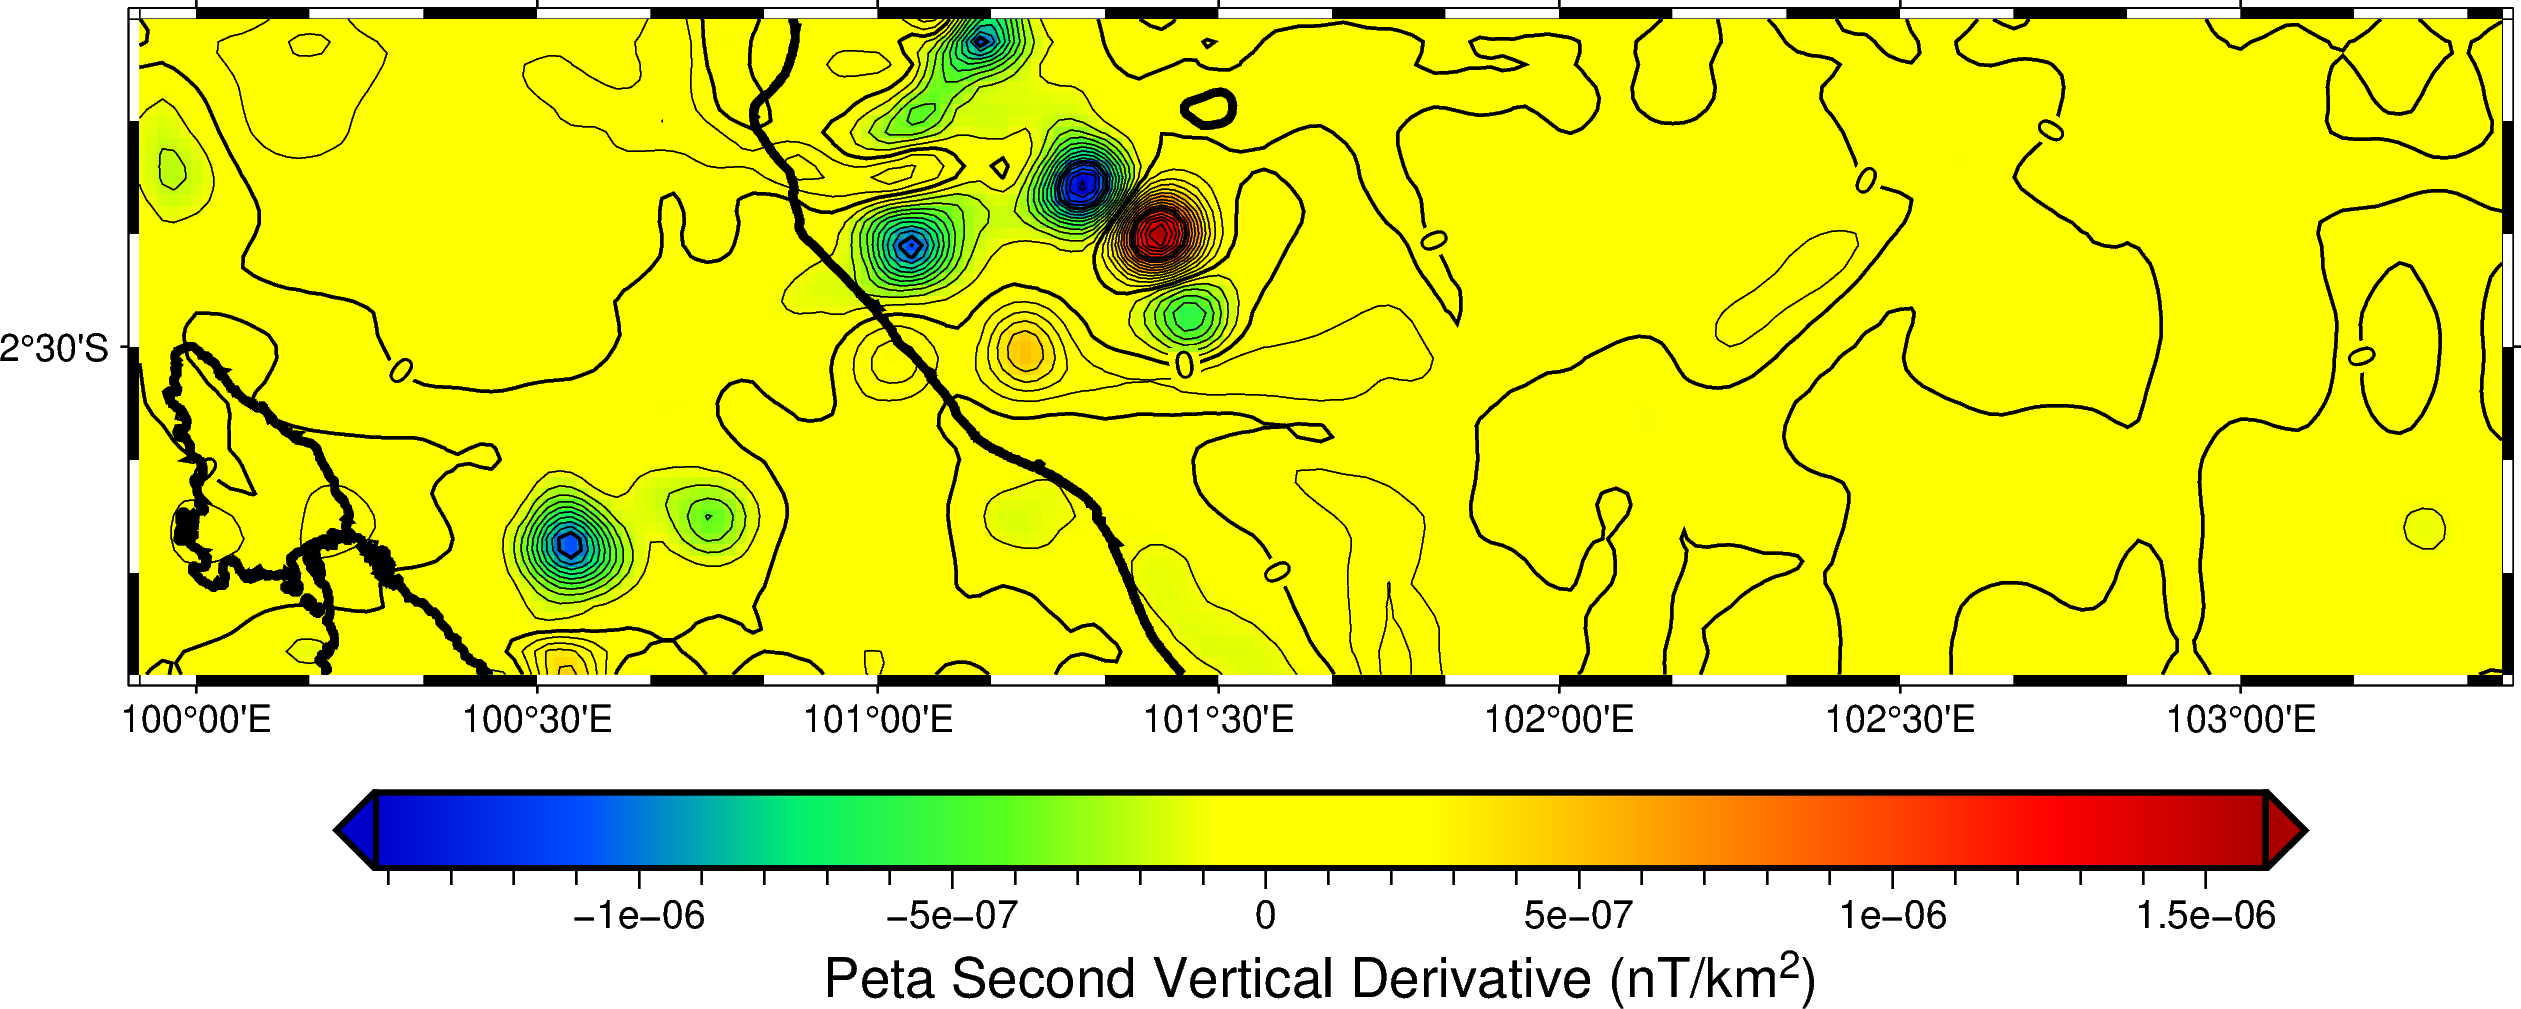

In [ ]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[SVD.min().values, SVD.max().values], background=True)
fig.basemap(projection='M20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=SVD, cmap=True)
fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=SVD, interval=0.0000001, annotation=0.000001)

# Add colorbar
fig.colorbar(frame='af+lPeta Second Vertical Derivative (nT/km@+2@+)', position="JBC+h+o0/1c+e")
fig.show()

**Download Data SVD**

In [ ]:
SVD_df = SVD.to_dataframe(name='SVD')
SVD_df.to_csv('SVD.csv')
files.download('SVD.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Membuat Irisan Melintang**

Buat slice atau irisan melintang dari data anomali medan magnet residual dengan memasukkan koordinat awal dan akhir dari garis slicenya

In [ ]:
min_lon = 100.5
max_lon = 101.75
min_lat = -2.75
max_lat = -2.05
lon_inc = 0.01 # interval sampling longitude
lat_inc = 0.01 # interval sampling latitude

if min_lon != max_lon:
  x = xr.DataArray(np.arange(min_lon, max_lon, lon_inc).tolist(), dims=['location'])
else:
  x = xr.DataArray([min_lon]*int((max_lat-min_lat)/lat_inc), dims=['location'])

if min_lat != max_lat:
#  y = xr.DataArray(np.arange(min_lat, max_lat, lat_inc).tolist(), dims=['location'])
#else:
  y = xr.DataArray([min_lat]*int((max_lon-min_lon)/lon_inc), dims=['location'])
print(len(x), len(y))
SlicedData = residual.sel(x=x, y=y, method='nearest')
SlicedData_FHD = FHD.sel(x=x, y=y, method='nearest')
SlicedData_SVD = SVD.sel(x=x, y=y, method='nearest')

125 125


Tampilkan lokasi garis slice nya

<ipython-input-114-1b23922f20b6>:8: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=residual, interval=20, annotation=20)


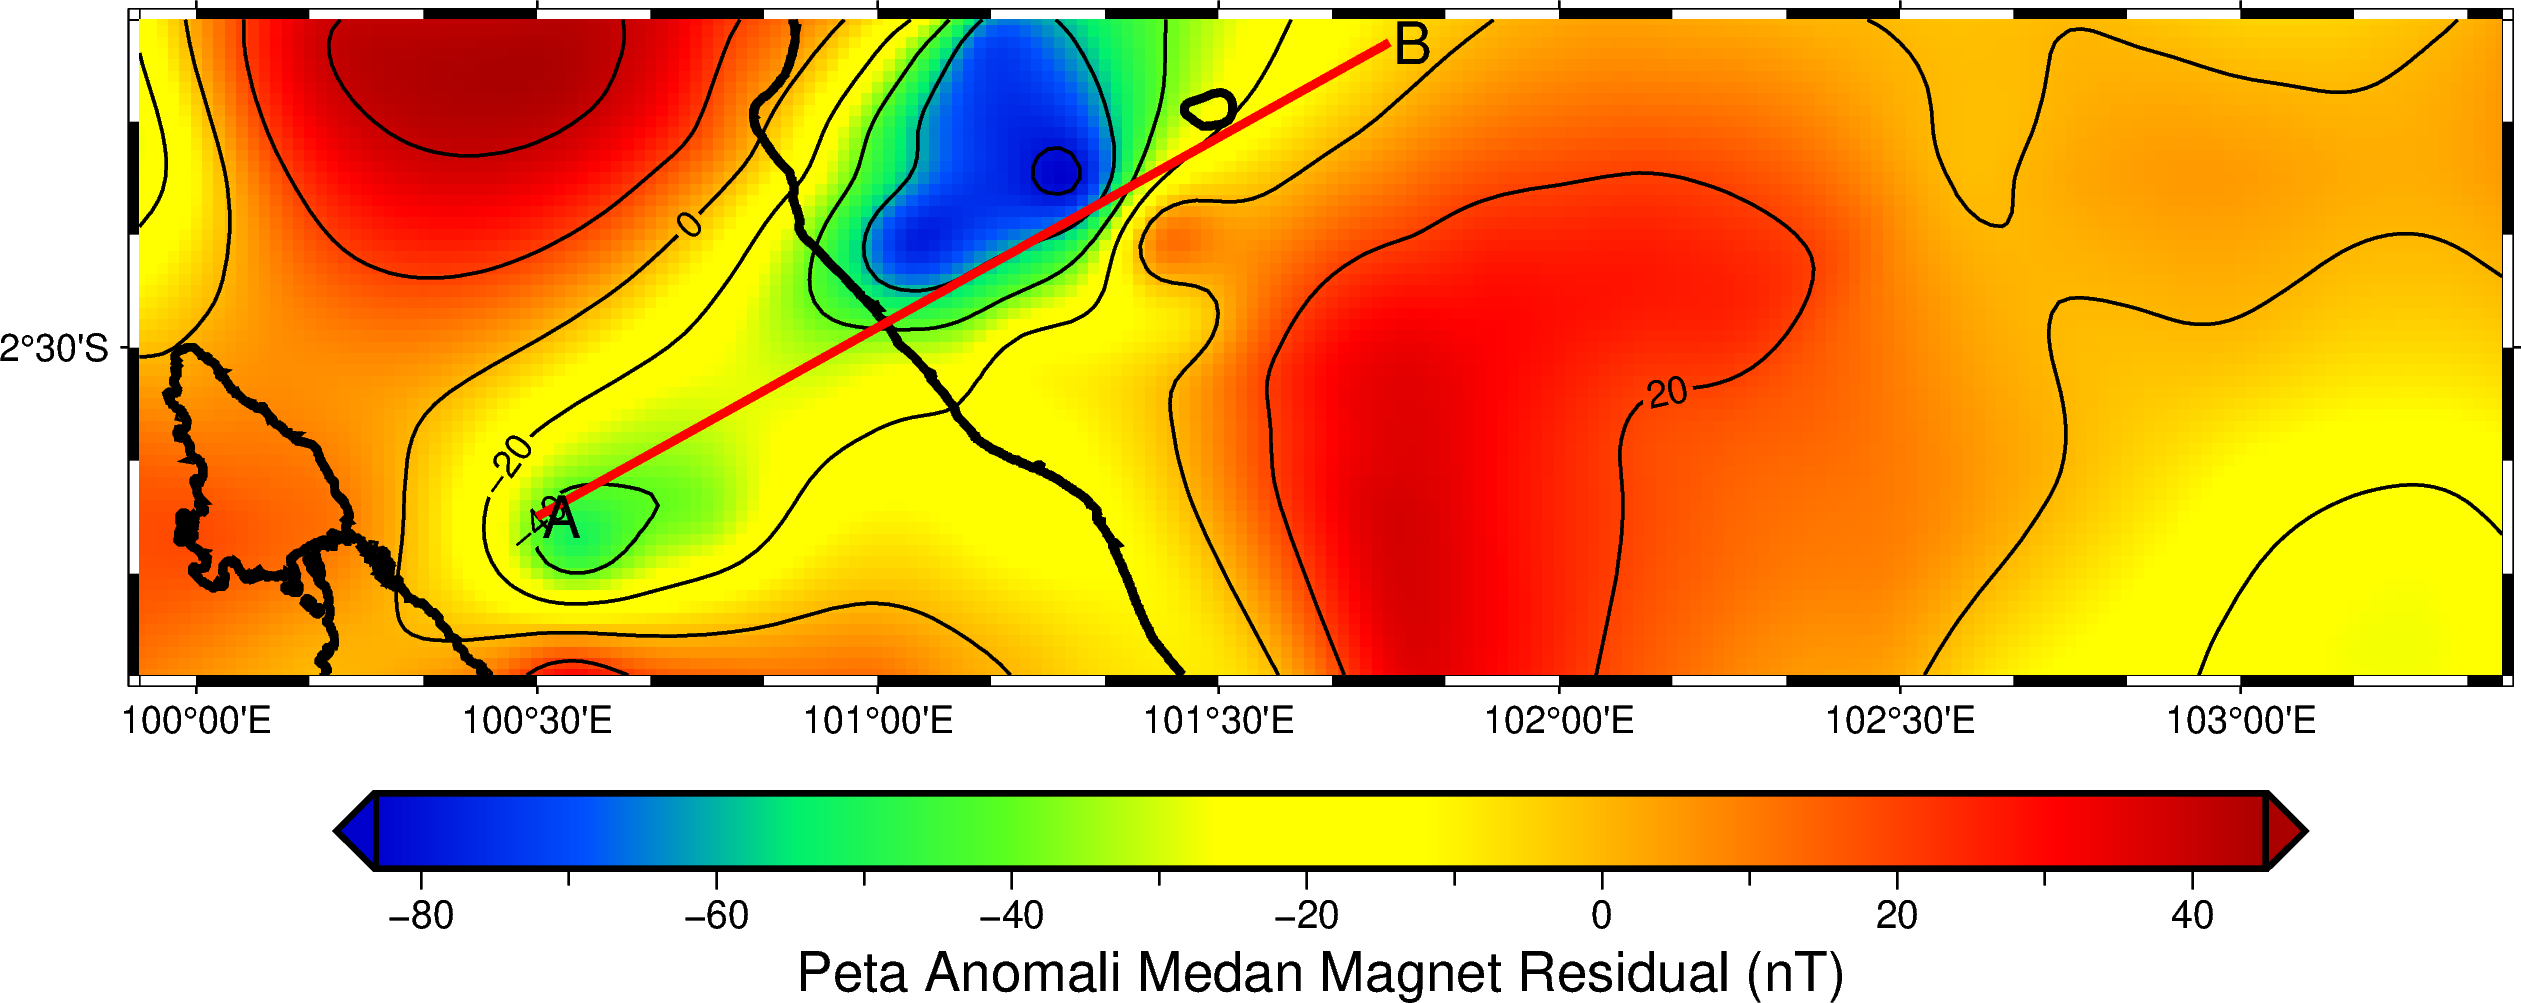

<ipython-input-114-1b23922f20b6>:25: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=FHD, interval=0.001, annotation=0.001)


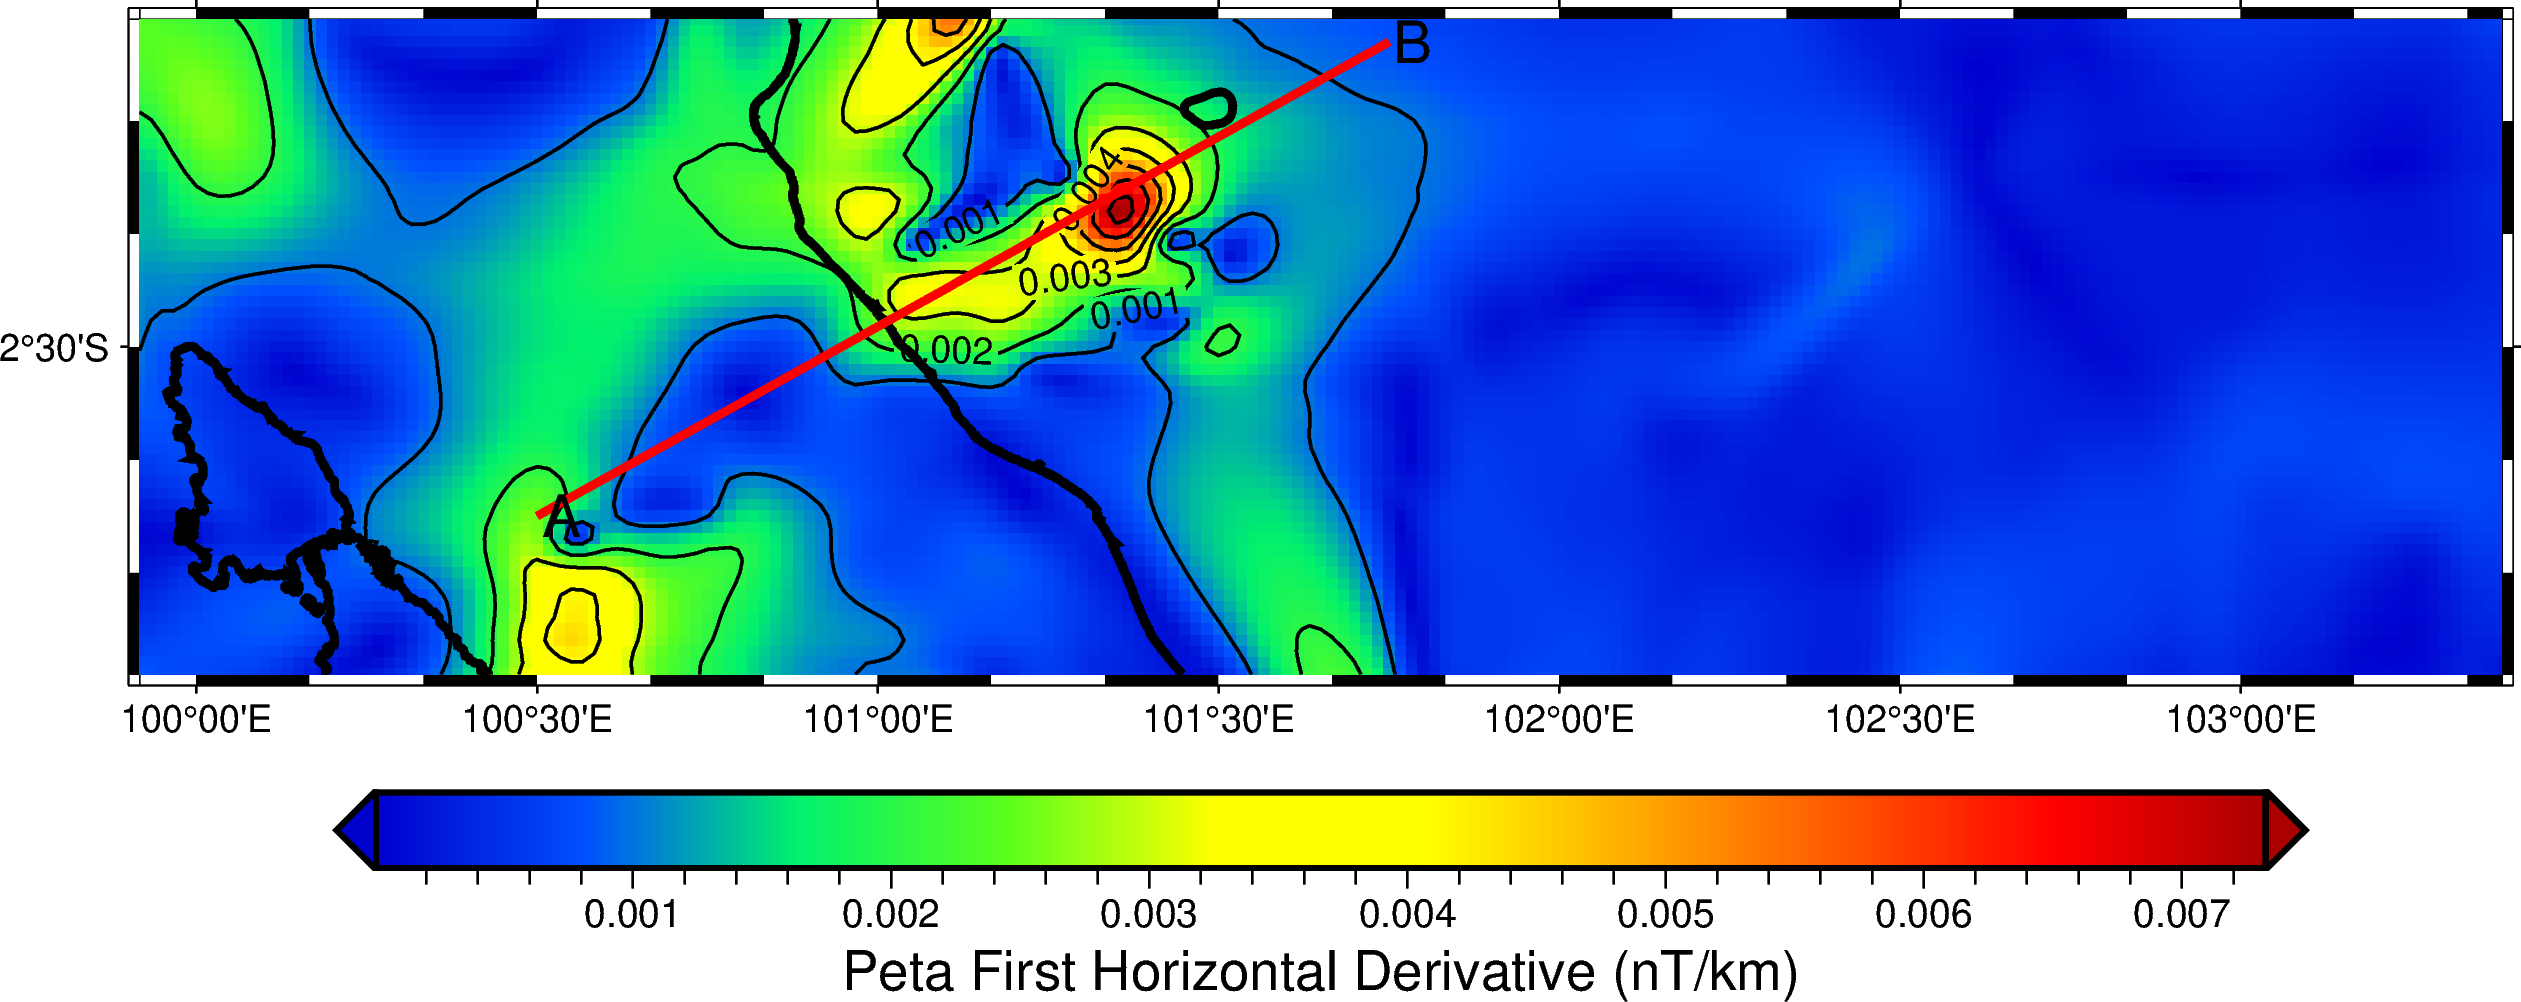

<ipython-input-114-1b23922f20b6>:42: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(grid=SVD, interval=0.0000001, annotation=0.0000001)


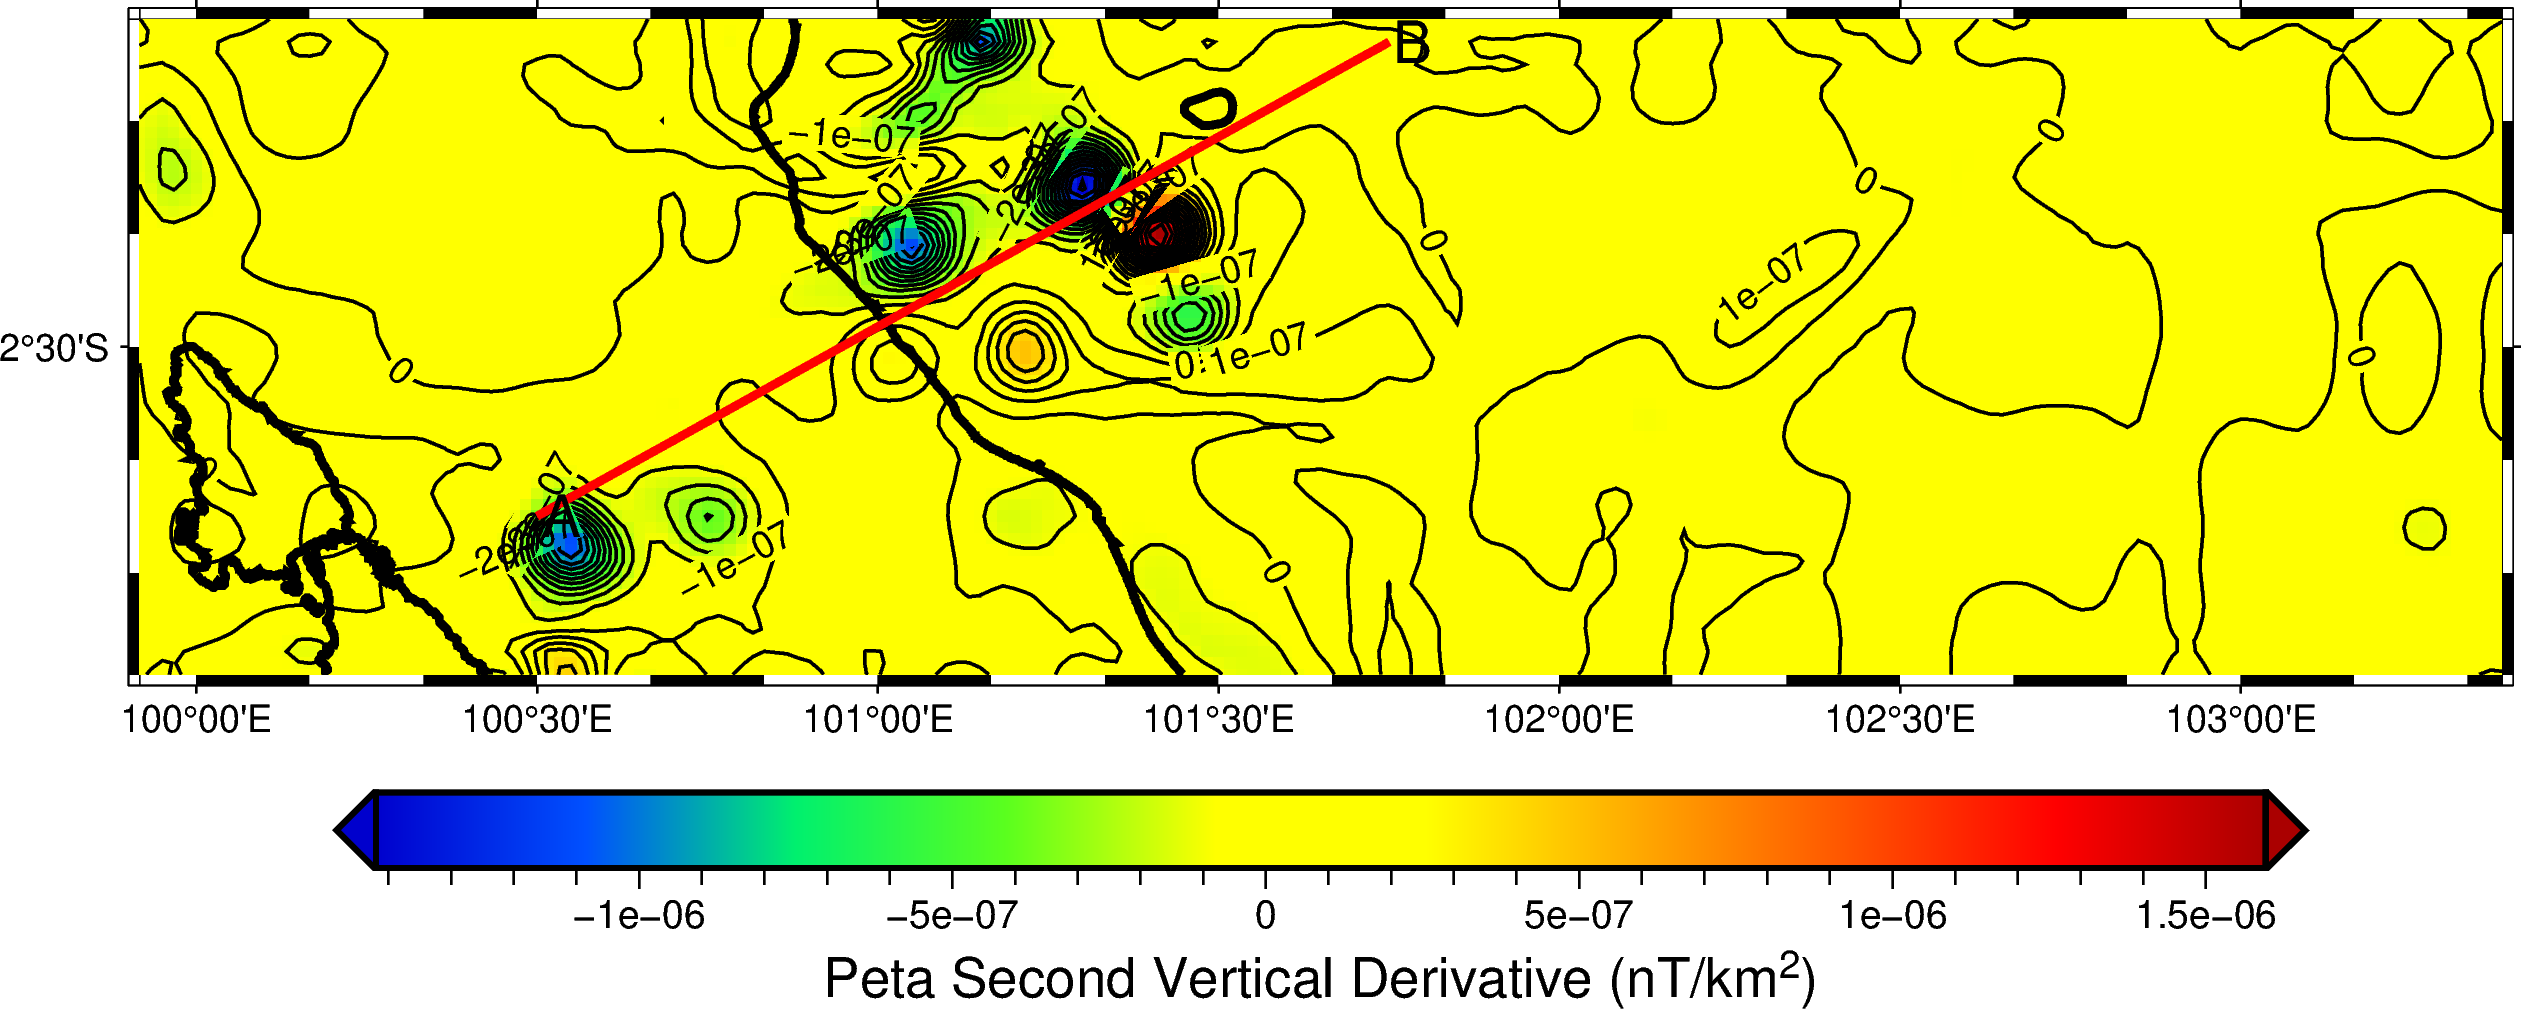

In [ ]:
#########################################
# Peta Anomali residual
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[residual.min().values, residual.max().values], background=True)
fig.basemap(projection='M20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=residual, cmap=True)
fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=residual, interval=20, annotation=20)

fig.plot(x=[min_lon, max_lon], y=[min_lat, max_lat], pen='2p,red')
fig.text(text='A', x=min_lon, y=min_lat, font='14p', offset='0.2/0')
fig.text(text='B', x=max_lon, y=max_lat, font='14p', offset='0.2/0')

# Add colorbar
fig.colorbar(frame='af+lPeta Anomali Medan Magnet Residual (nT)', position="JBC+h+o0/1c+e")
fig.show()

#########################################
# Peta FHD
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[FHD.min().values, FHD.max().values], background=True)
fig.basemap(projection='M20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=FHD, cmap=True)
fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=FHD, interval=0.001, annotation=0.001)

fig.plot(x=[min_lon, max_lon], y=[min_lat, max_lat], pen='2p,red')
fig.text(text='A', x=min_lon, y=min_lat, font='14p', offset='0.2/0')
fig.text(text='B', x=max_lon, y=max_lat, font='14p', offset='0.2/0')

# Add colorbar
fig.colorbar(frame='af+lPeta First Horizontal Derivative (nT/km)', position="JBC+h+o0/1c+e")
fig.show()

#########################################
# Peta SVD
fig = pygmt.Figure()
pygmt.makecpt(cmap="seis+h", reverse=True, series=[SVD.min().values, SVD.max().values], background=True)
fig.basemap(projection='M20', region=[lon_min, lon_max, lat_min, lat_max], frame=True)
fig.grdimage(grid=SVD, cmap=True)
fig.coast(resolution='f', shorelines='2p,black,solid')
fig.grdcontour(grid=SVD, interval=0.0000001, annotation=0.0000001)

fig.plot(x=[min_lon, max_lon], y=[min_lat, max_lat], pen='2p,red')
fig.text(text='A', x=min_lon, y=min_lat, font='14p', offset='0.2/0')
fig.text(text='B', x=max_lon, y=max_lat, font='14p', offset='0.2/0')

# Add colorbar
fig.colorbar(frame='af+lPeta Second Vertical Derivative (nT/km@+2@+)', position="JBC+h+o0/1c+e")
fig.show()

Buat variabel data, lintang, dan bujur dari data hasil slice

In [ ]:
mag_data = SlicedData.to_numpy()
FHD_data = SlicedData_FHD.to_numpy()
SVD_data = SlicedData_SVD.to_numpy()
lat_data = SlicedData.y.to_numpy()
lon_data = SlicedData.x.to_numpy()

Hitung jarak setiap data dari koordinat awal dalam kilometer



In [ ]:
g = Geod(ellps='WGS84')
distance = []
for i in range(len(mag_data)):
  azimuth1, azimuth2, distance_2d = g.inv(lon_data[0], lat_data[0], lon_data[i], lat_data[i])
  distance += [distance_2d/1000]

Tampilkan hasil slice

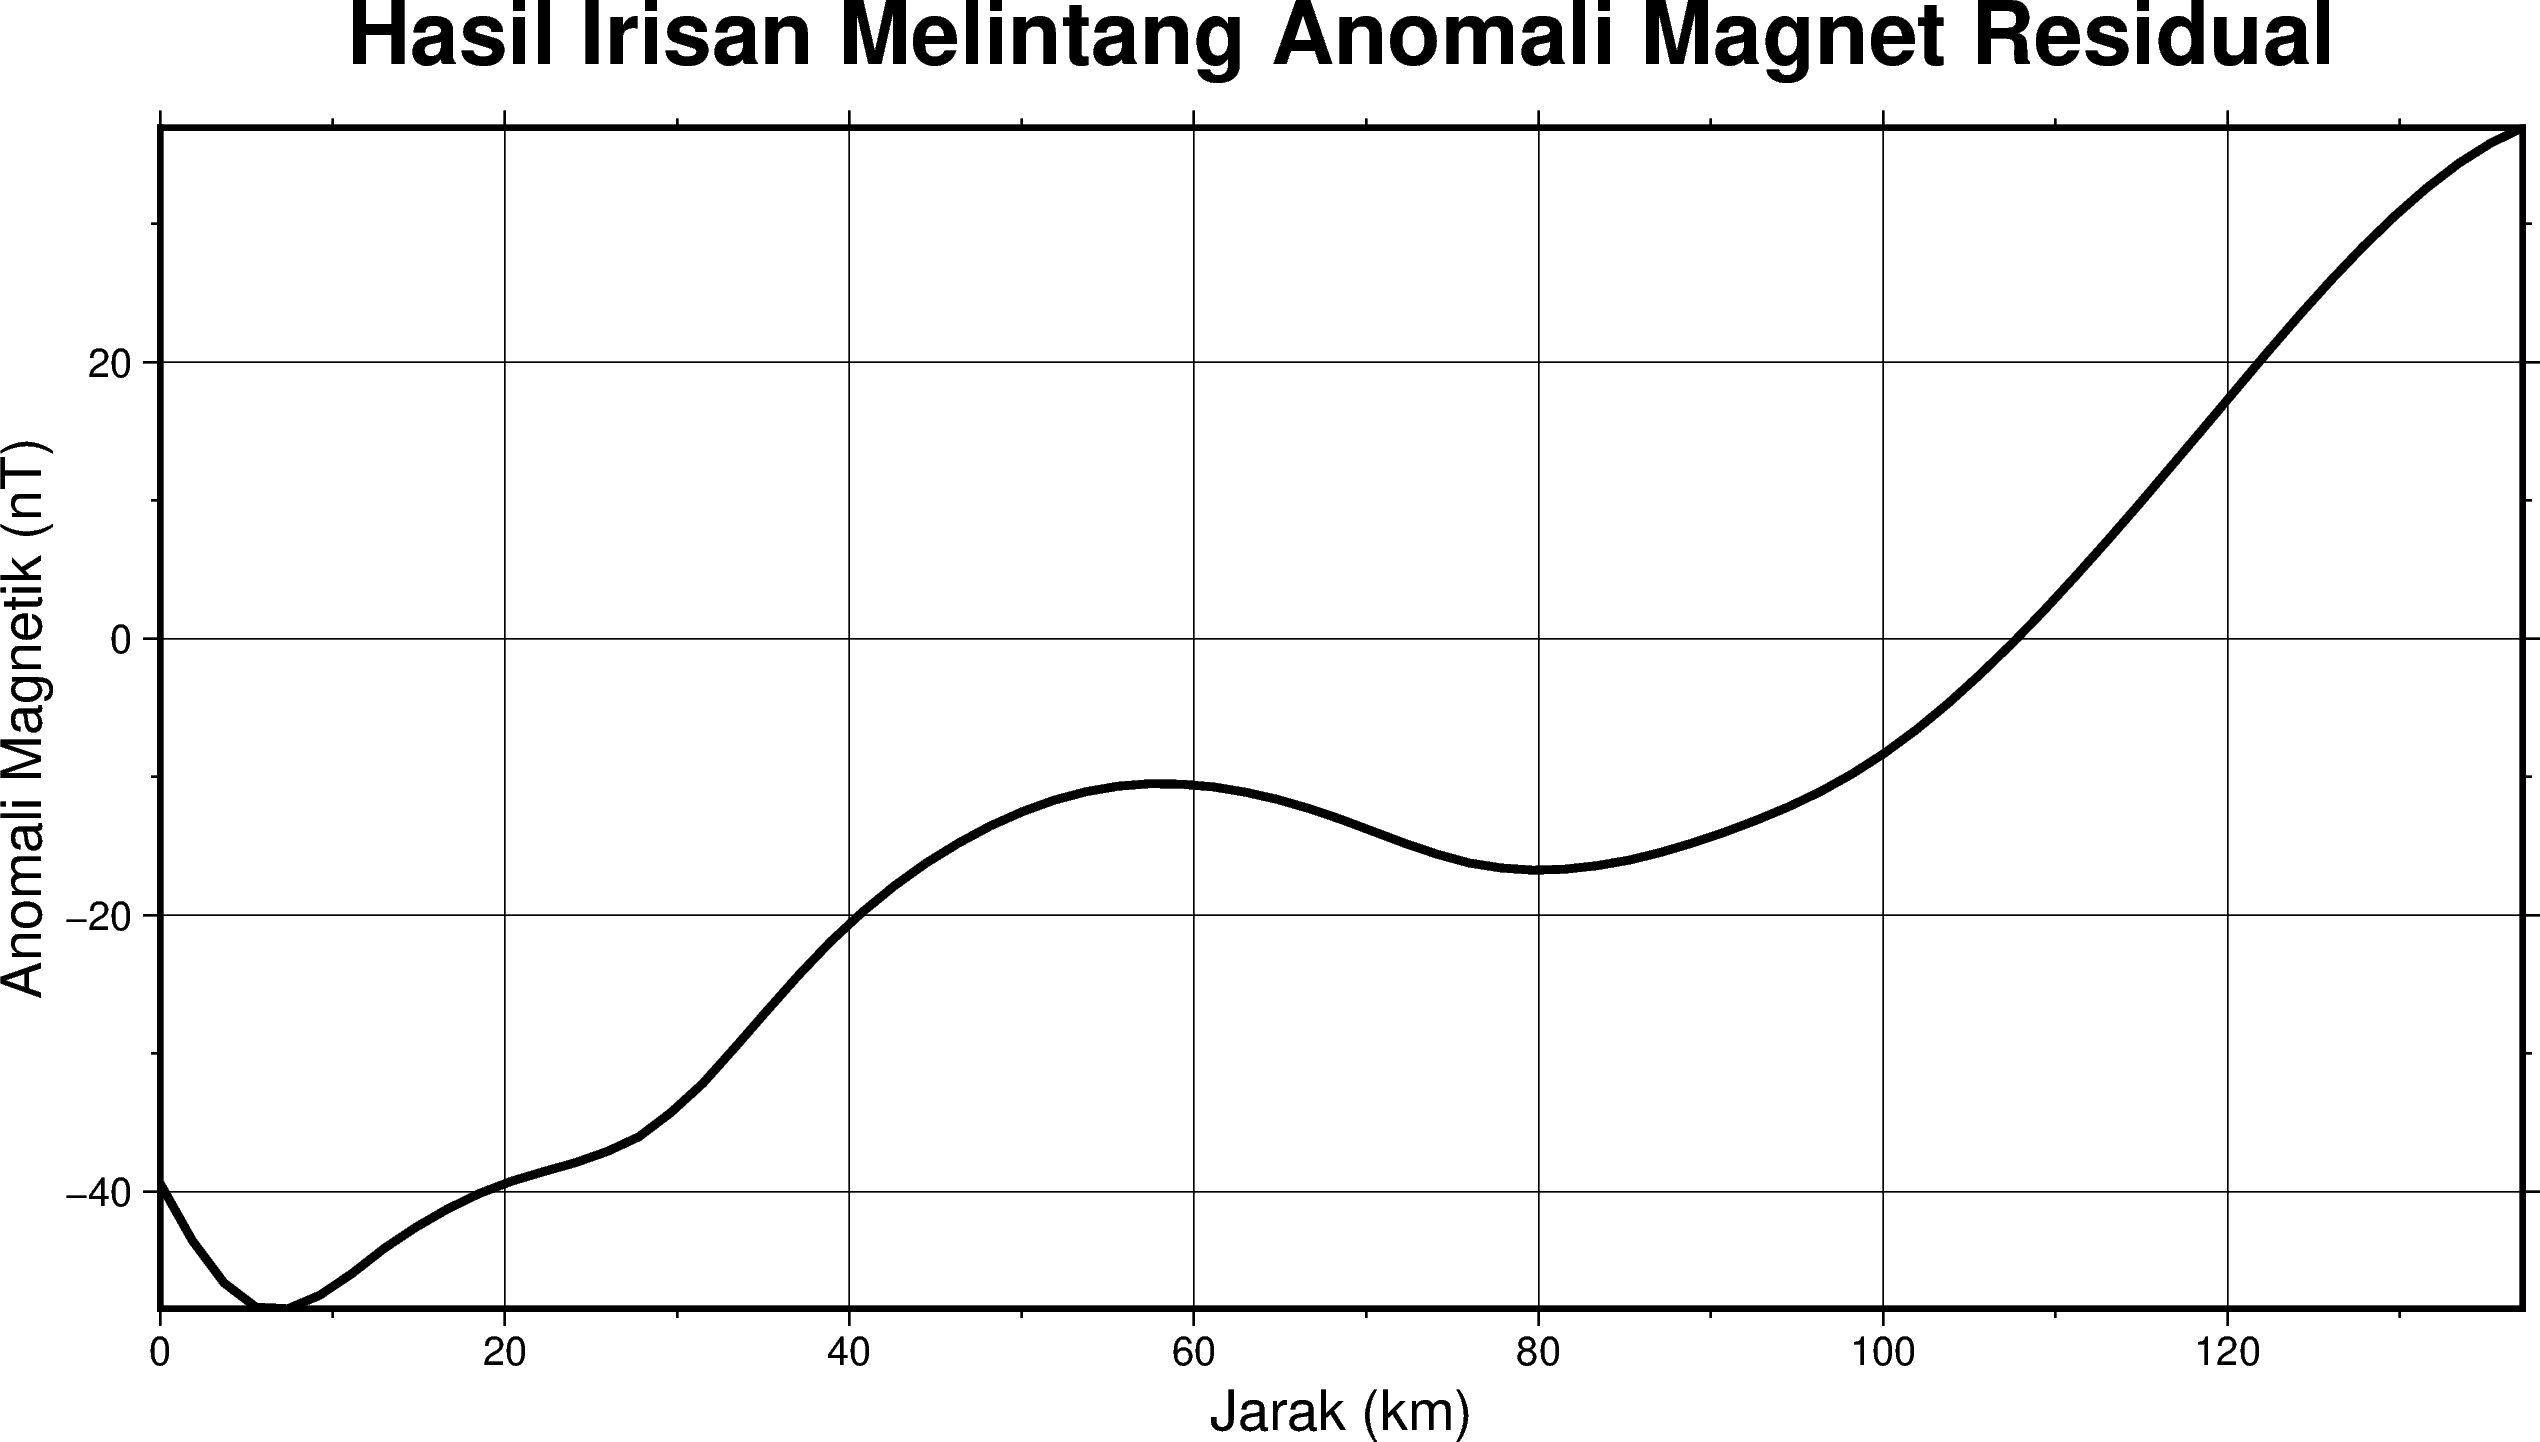

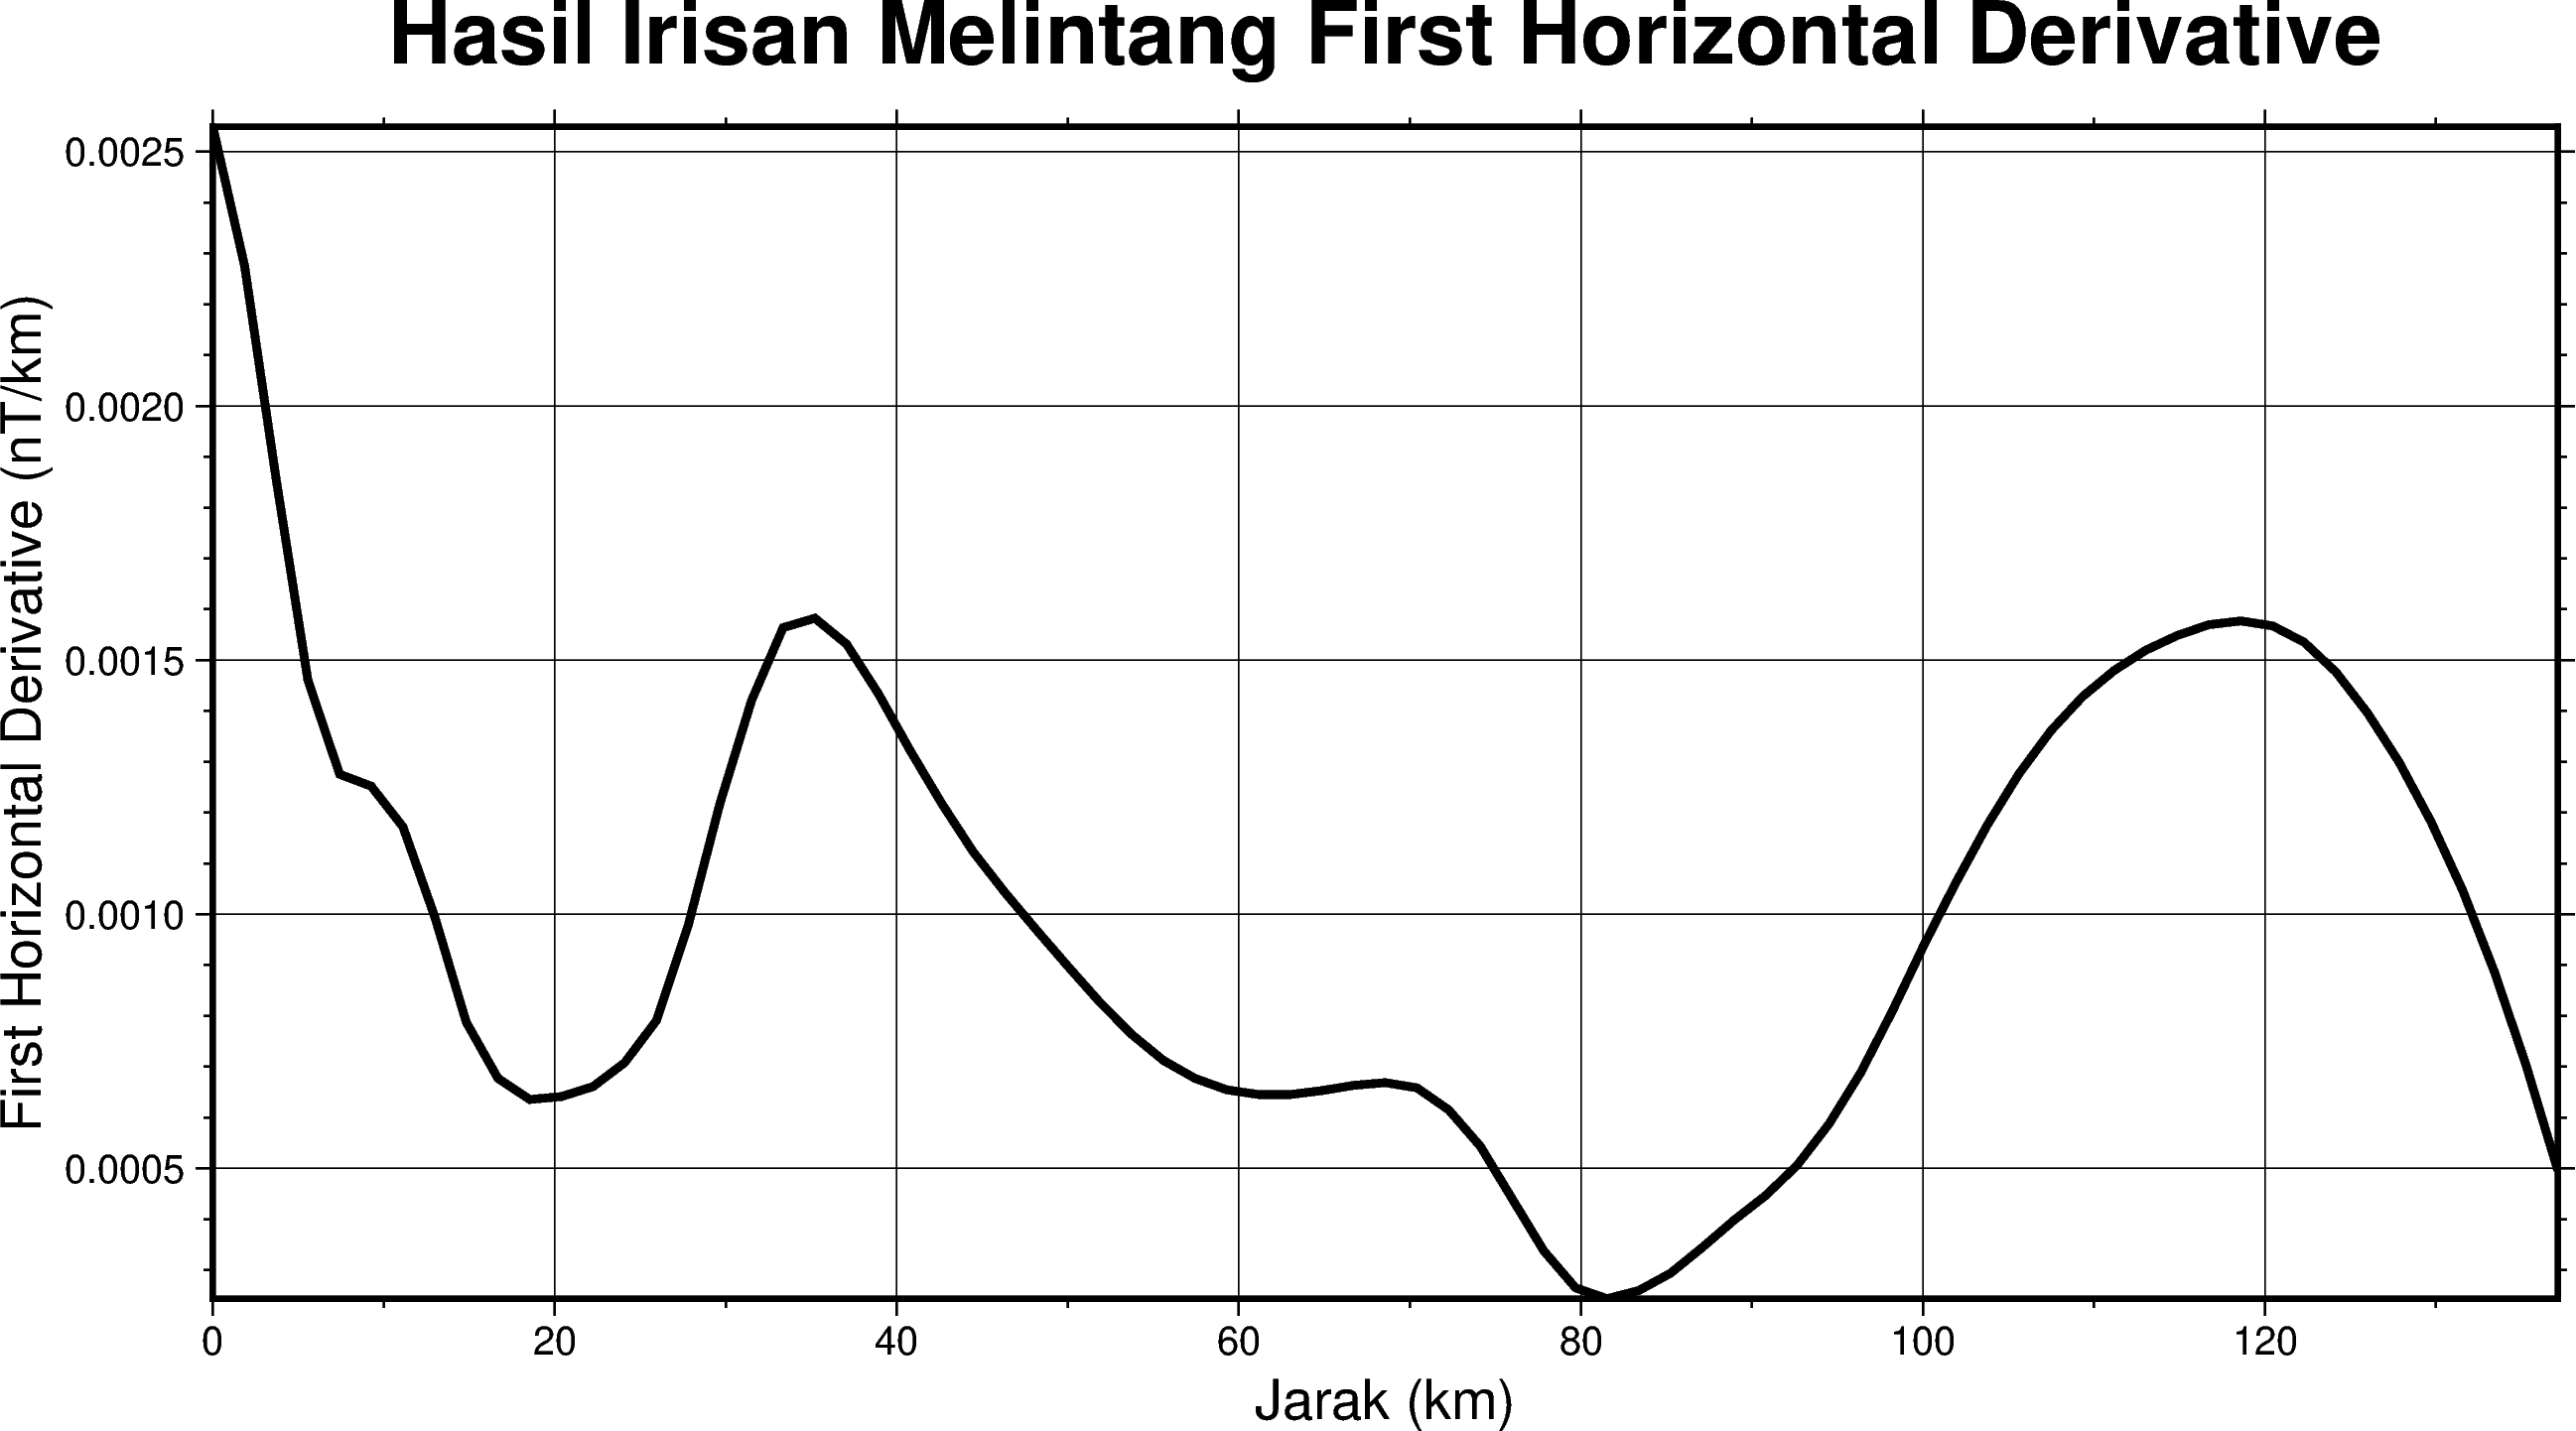

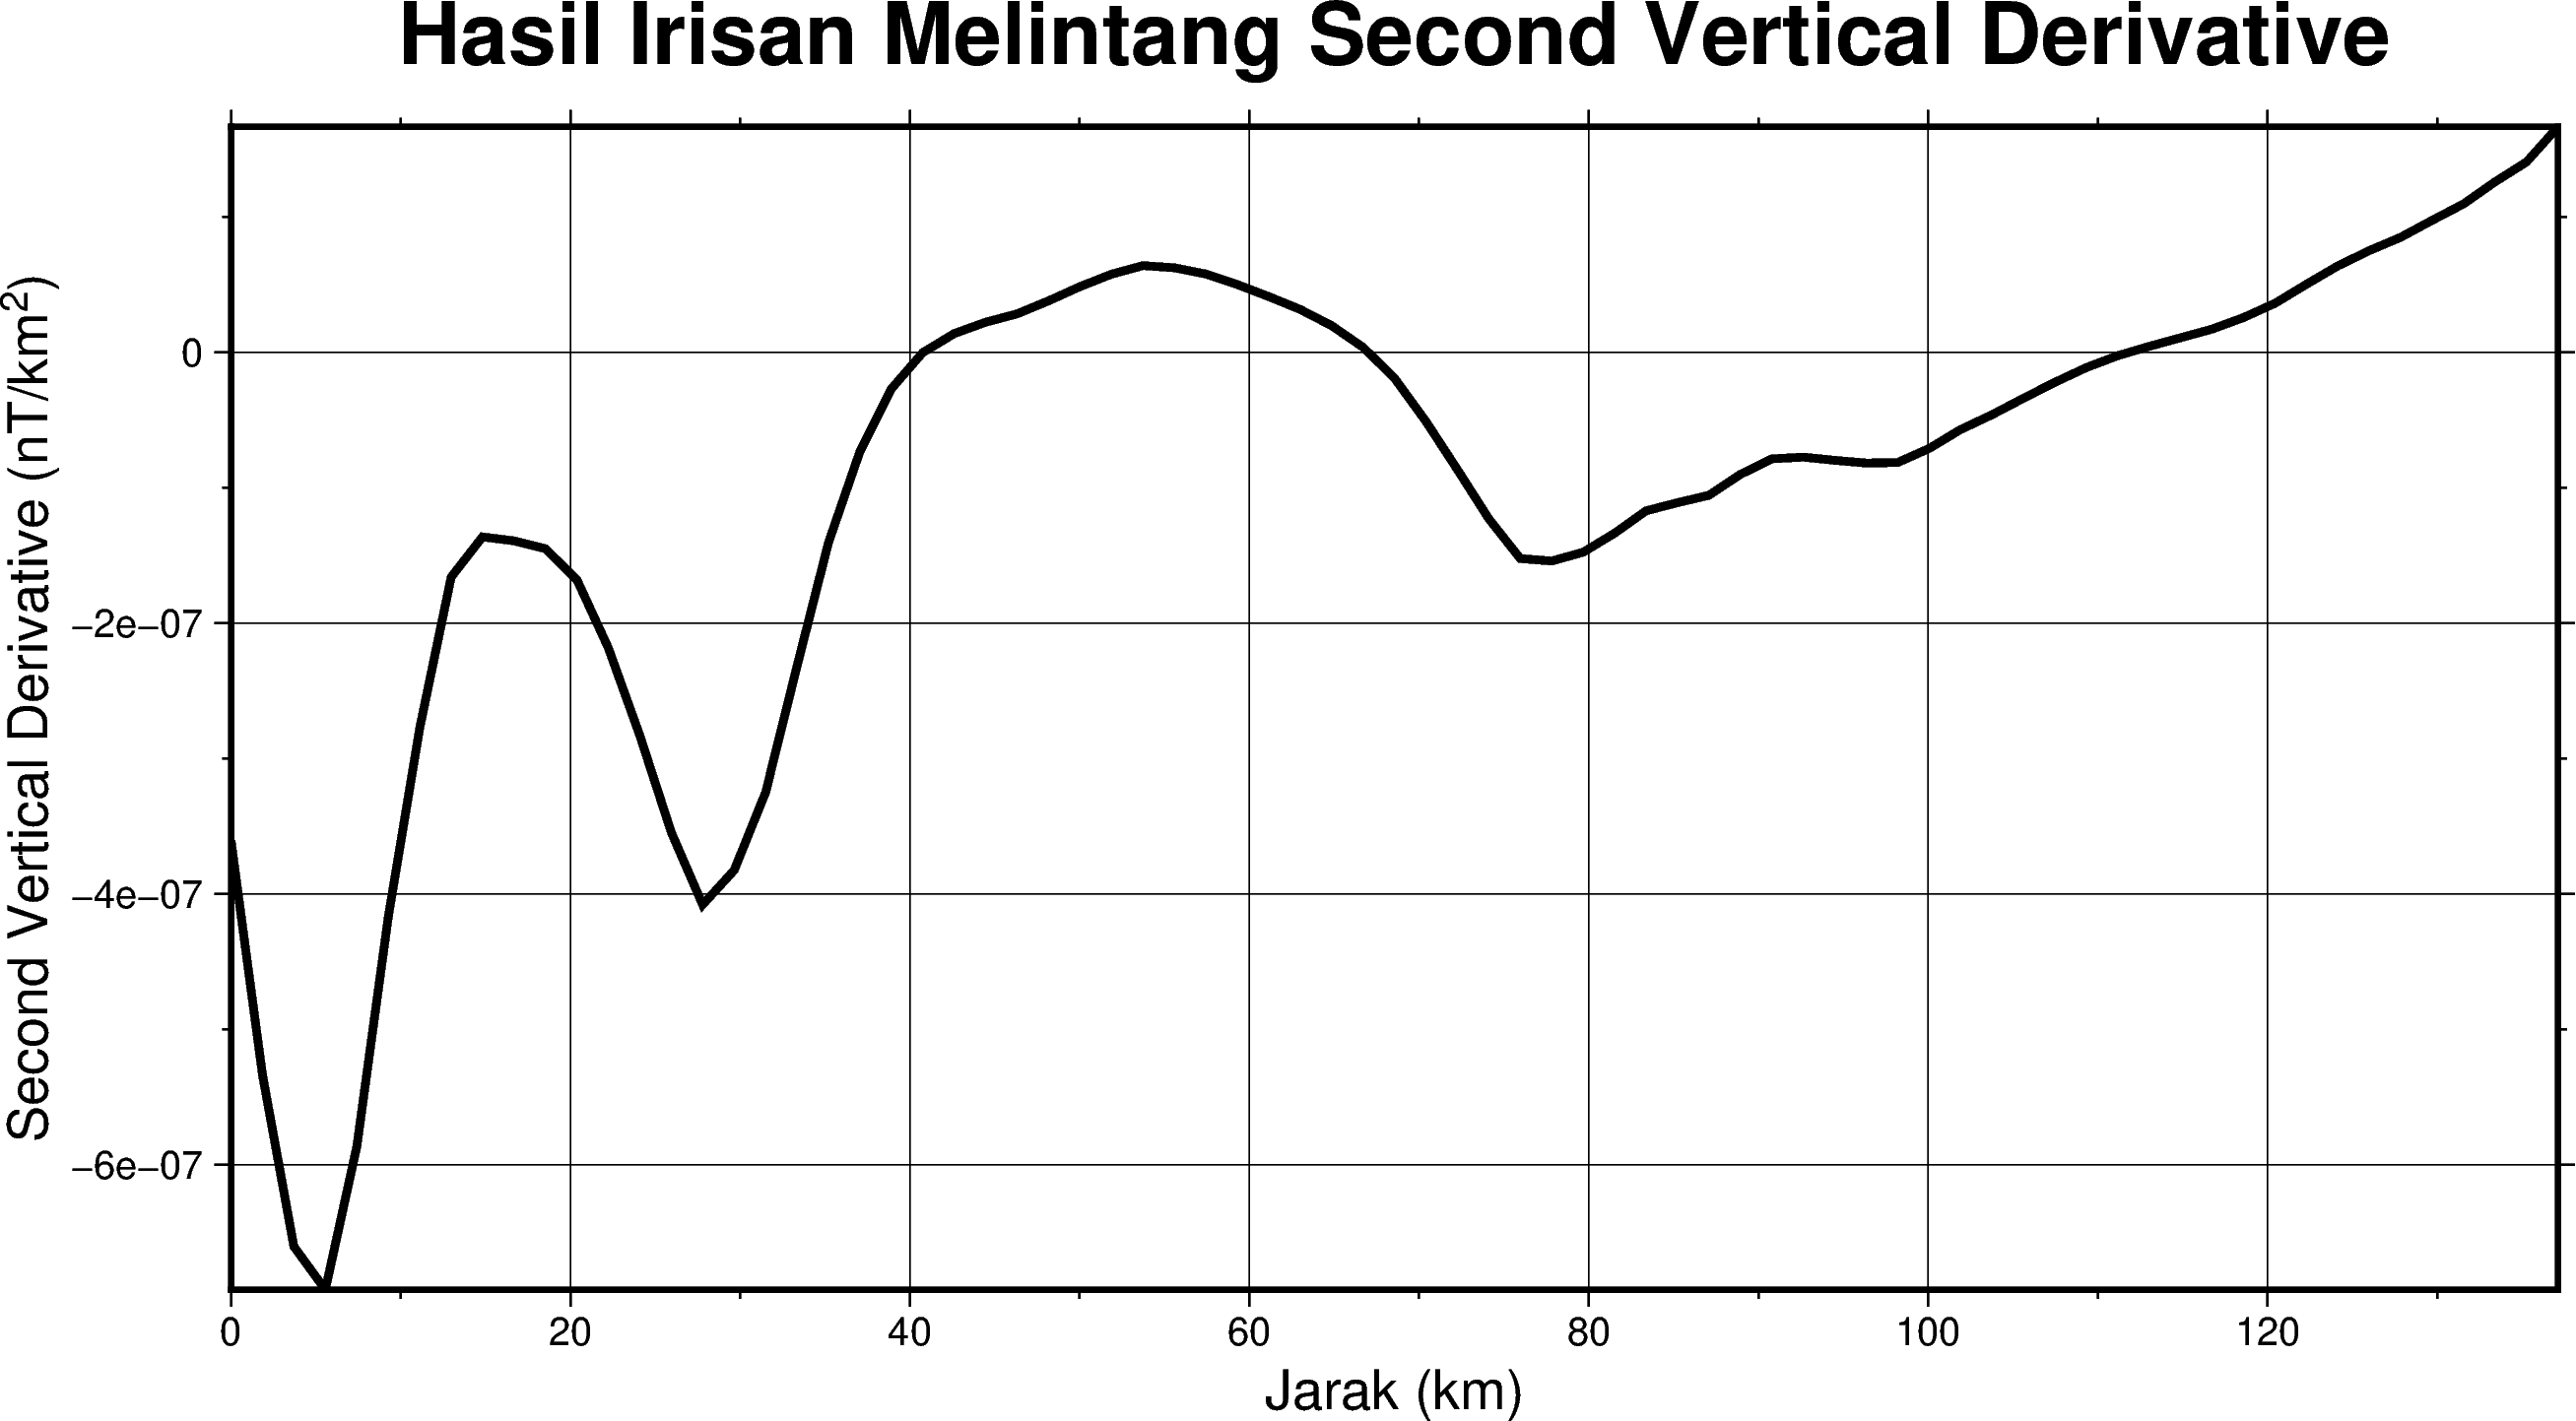

In [ ]:
###########################################
# Slice anomali residual
df = pd.DataFrame({'Jarak': distance, 'Mag': mag_data})

fig = pygmt.Figure()
fig.basemap(projection='X20/10', region=[min(df['Jarak'],), max(df['Jarak'],), min(df['Mag']), max(df['Mag'])],
            frame=["xafg+lJarak (km)",
            "yafg+lAnomali Magnetik (nT)",
            "WSen+tHasil Irisan Melintang Anomali Magnet Residual"])
fig.plot(x=df['Jarak'], y=df['Mag'], pen='2p')
fig.show()

###########################################
# Slice FHD
df_FHD = pd.DataFrame({'Jarak': distance, 'Mag': FHD_data})

fig = pygmt.Figure()
fig.basemap(projection='X20/10', region=[min(df_FHD['Jarak'],), max(df_FHD['Jarak'],), min(df_FHD['Mag']), max(df_FHD['Mag'])],
            frame=["xafg+lJarak (km)",
            "yafg+lFirst Horizontal Derivative (nT/km)",
            "WSen+tHasil Irisan Melintang First Horizontal Derivative"])
fig.plot(x=df_FHD['Jarak'], y=df_FHD['Mag'], pen='2p')
fig.show()

###########################################
# Slice SVD
df_SVD = pd.DataFrame({'Jarak': distance, 'Mag': SVD_data})

fig = pygmt.Figure()
fig.basemap(projection='X20/10', region=[min(df_SVD['Jarak'],), max(df_SVD['Jarak'],), min(df_SVD['Mag']), max(df_SVD['Mag'])],
            frame=["xafg+lJarak (km)",
            "yafg+lSecond Vertical Derivative (nT/km@+2@+)",
            "WSen+tHasil Irisan Melintang Second Vertical Derivative"])
fig.plot(x=df_SVD['Jarak'], y=df_SVD['Mag'], pen='2p')
fig.show()

Simpan data slice anomali residual dalam format ".DAT"

In [ ]:
df.to_csv('slice_residual.dat', sep=',', index=False, lineterminator='\r\n')
files.download('slice_residual.dat')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Simpan data slice FHD dalam format ".DAT"

In [ ]:
df_FHD.to_csv('slice_FHD.dat', sep=',', index=False, lineterminator='\r\n')
files.download('slice_FHD.dat')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Simpan data slice SVD dalam format ".DAT"

In [ ]:
df_SVD.to_csv('slice_SVD.dat', sep=',', index=False, lineterminator='\r\n')
files.download('slice_SVD.dat')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Referensi**



> Arifin, Y. I. (2019). Kemagnetan Batuan (Anisotropi Batuan Beku). UNG Press Gorontalo.

> Constable, C.G., and Constable, S.C., (2004). Satellite magnetic field measurements: applications in studying the deep earth. In Sparks, R.S.J., and Hawkesworth, C.J., (eds.), The State of the Planet: Frontiers and Challenges in Geophysics. Washington, DC: American Geophysical Union, doi: 10.1029/150GM13, pp. 147–160.

> Fenoglio, M. A., Johnston, M.J.S., dan Byerlee, J.D. (1995). Magnetic and Electric Fields Associated with Changes in High Pore Pressure in Fault Zone-Application to the Loma Prieta ULF Emissions, J. Geophys. Res. 100, pp 12951-12958.

> Freund, F.T. (2007). Pre-Earthquake Signals-Part I: Deviatoric Stresses Turn Rocks into A Source of Electric Currents, Natural Hazards Earth System Science, pp 535-541.

> Hattori, K. (2004). ULF geomagnetic changes associated with large earthquakes, Terr. Atmos. OceanSci., vol. 15,no. 3, pp. 329–360.

> Ismaguilov, V. S., Kopytenko, Yu. A., Hattori, K., and Hayakawa, M. (2003). Variations of phase velocity and gradient values of ULF geomagnetic disturbances connected with the Izu strong earthquakes, Nat. Hazards Earth Syst. Sci., 3, 211–215, https://doi.org/10.5194/nhess-3-211-2003.

> Kolhatkar, A., Jamison, A., Litvinov, D., Willson, R., & Lee, T. (2013). Tuning the Magnetic Properties of Nanoparticles. International Journal of Molecular Sciences, 14(8), 15977–16009. MDPI AG. Retrieved from http://dx.doi.org/10.3390/ijms14081597

> Kopytenko, Y. & Ismagilov, V. & Hayakawa, Masashi & Smirnova, N. & Troyan, V. & Peterson, T.. (2001). Investigation of the ULF electromagnetic phenomena related to earthquakes: Contemporary achievements and the perspectives. Annali di Geofisica. 44. 325-334.

> Merzer, M., dan Klemperer, S.L. (1997). Modelling Low-Frequency Magnetik Field Prekursors to the Loma Prieta Earthquake with A Prekursory Increase in Fault Zone Conductivity, Pure Applied Geophysics, Vol. 150, pp 217-248.

> Molchanov, O.A., dan Hayakawa, M. (1998). On the Generation Mechanism of ULF Seismogenic Emissions, Physics Earth Planet International, Vol. 105, pp 210-210.

> Nettleton, L. L. (1962). Gravity and Magnetics for Geologists and Seismologists. AAPG Bulletin, Vol. 46, No. 10, pp. 1815-1838

> Ravat, D. (2007). Reduction to Pole. In: Gubbins, D., Herrero-Bervera, E. (eds) Encyclopedia of Geomagnetism and Paleomagnetism. Springer, Dordrecht. https://doi.org/10.1007/978-1-4020-4423-6_275

> Santosa, Bagus J., Mashuri, Sutrisno, Wahyu T., Wafi, A., Salim, R., dan Armi, R. (2012). Interpretasi Metode Magnetik untuk Penentuan Struktur Bawah Permukaan di Sekitar Gunung Kelud Kabupaten Kediri. Jurnal Penelitian Fisika dan Aplikasinya (JPFA), Vol. 2 No. 1, Juni 2012. ISSN: 2087-9946.

> Uieda, L., V. C. Oliveira Jr, and V. C. F. Barbosa (2013), Modeling the Earth with Fatiando a Terra, Proceedings of the 12th Python in Science Conference, pp. 91-98. doi:10.25080/Majora-8b375195-010

> Uieda, L., Tian, D., Leong, W. J., Schlitzer, W., Grund, M., Jones, M., Fröhlich, Y., Toney, L., Yao, J., Magen, Y., Tong, JH., Materna, K., Belem, A., Newton, T., Anant, A., Ziebarth, M., Quinn, J., and Wessel, P. (2023). PyGMT: A Python interface for the Generic Mapping Tools (Version 0.9.0). doi:10.5281/zenodo.7772533